# 1 - Exploration du dataset Jeux Ps5 - Playstation Store

## Objectifs de ce notebook

Dans ce notebook, nous allons parcourir le dataset et réaliser des statistiques descriptives.

- Vérifier la qualité des données
- Vérifier la cohérence des données
- Quantifier les données manquantes
- Voir les corrélations

## Données utilisées

Utilisation du fichier csv nettoyé extrait du fichier JSON raw construit depuis les APIs

**data/processed/games_data.csv**.

## Import librairies

In [394]:
import sys
from pathlib import Path
import os
import json
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.preprocessing import MultiLabelBinarizer

# Ajouter le dossier parent src au path
sys.path.append(os.path.abspath('..'))

%matplotlib inline


## CONSTANTES

In [395]:
EXTRACT_DATE = datetime(2025, 11, 1, 17, 2, 28)

PRICE_SEGMENTS = [
    {
        "label": "0 - 7.99",
        "value_min": 0,
        "value_max": 7.99,
    },
    {
        "label": "8 - 14.99",
        "value_min": 8,
        "value_max": 14.99,
    },
    {
        "label": "15 - 24.99",
        "value_min": 15,
        "value_max": 24.99,
    },
    {
        "label": "25 - 39.99",
        "value_min": 25,
        "value_max": 39.99,
    },
    {
        "label": "40+",
        "value_min": 40,
        "value_max": 150,
    },
]


WAIT_DISCOUNT_SEGMENTS = [
    {
        "label": "0-3_mois",
        "value_min": 0,
        "value_max": 90,
    },
    {
        "label": "3-6_mois",
        "value_min": 91,
        "value_max": 180,
    },
    {
        "label": "6-12_mois",
        "value_min": 181,
        "value_max": 365,
    },
    {
        "label": "1-2_ans",
        "value_min": 366,
        "value_max": 730,
    },
    {
        "label": "jamais_ou_plus",
        "value_min": 731,
        "value_max": float('inf'),
    },
]


PROMOS = [10,25,33,50,75]


## Chargement des données

In [396]:
# Fichier stocké temporairement sur un de mes S3
# url = "https://d3aok2axxchxf9.cloudfront.net/ia/games_data.csv"

url = os.path.join(Path.cwd().parent, "data/processed/games_data.csv")

# Charger les données CSV, Les colonnes Boolean sont au format Int64 (0,1,NaN)
df = pd.read_csv(url,dtype={
    'trophies_count': 'Int64',
    'local_multiplayer_max_players': 'Int64',
    'online_multiplayer_max_players': 'Int64',
    'difficulty': 'Int64',
    'download_size': 'Int64',
    'hours_main_story': 'Int64',
    'hours_completionist': 'Int64',
    'metacritic_critic_score': 'Int64',
    'metacritic_critic_userscore': 'Int64',
    'pegi_rating': 'Int64',
})

## EDA - Analyse exploratoire détaillée

In [397]:
def column_summary(df: pd.DataFrame):
    summary = []
    for col in df.columns:
        col_type = df[col].dtype
        non_null = df[col].notna().sum()
        null_count = df[col].isna().sum()
        
        # Gérer le cas où la colonne contient des listes (unhashable)
        try:
            unique_count = df[col].nunique()
        except TypeError:
            # Si erreur (listes), convertir en string temporairement
            unique_count = df[col].astype(str).nunique()
            print(f"⚠️ Colonne '{col}' contient des types non-hashable (probablement des listes)")

        summary.append({
            'Column': col,
            'Type': str(col_type),
            'Non-Null Count': non_null,
            'Null Count': null_count,
            'Unique Values': unique_count,
        })

    # Afficher le résumé des colonnes
    print("=" * 80)
    print("Résumé détaillé des colonnes:")
    print("=" * 80)
    column_summary_df = pd.DataFrame(summary)
    print(column_summary_df.to_string(index=False))
    print("\n")

In [398]:
column_summary(df)

Résumé détaillé des colonnes:
                        Column    Type  Non-Null Count  Null Count  Unique Values
                     game_name  object            5382           0           5382
                      id_store  object            5382           0           5382
                short_url_name  object            5382           0           5382
                     publisher  object            5382           0           1061
                     developer  object            3920        1462           2709
                  release_date  object            5382           0           1347
         pssstore_stars_rating float64            5382           0            352
   pssstore_stars_rating_count   int64            5382           0           1583
       metacritic_critic_score   Int64            1268        4114             67
   metacritic_critic_userscore   Int64            1268        4114             10
                        genres  object            5360          22  

In [399]:
df.head()

,game_name,id_store,short_url_name,publisher,developer,release_date,pssstore_stars_rating,pssstore_stars_rating_count,metacritic_critic_score,metacritic_critic_userscore,...,hours_main_story,hours_completionist,pegi_rating,esrb_rating,rating_descriptions,voice_languages,subtitle_languages,base_price,lowest_price,price_history
0,"#Halloween, Super Puzzles Dream",EP8311-PPSA19174_00-0421646910657705,game-halloween-super-puzzles-dream-ps5,e-llusiontertainment,NaN,2023-10-30,1.57,14,<NA>,<NA>,...,<NA>,<NA>,7,Everyone,Fear/Horror,NaN,NaN,4.99,1.49,"[{""x"": ""2023-11-02"", ""y"": 4.99}, {""x"": ""2023-1..."
1,#SinucaAttack,EP2005-PPSA06055_00-SINUCA0000000000,game-sinucaattack-ps5,eastasiasoft,NaN,2022-05-19,3.26,72,<NA>,<NA>,...,0,0,3,Everyone,Fantasy Violence,NaN,NaN,4.99,1.49,"[{""x"": ""2022-05-21"", ""y"": 4.99}, {""x"": ""2022-1..."
2,"#Wish travel, super puzzle dreams",EP8311-PPSA16513_00-0233078860249892,game-wish-travel-super-puzzle-dreams-ps5,e-llusiontertainment,NaN,2023-05-31,1.55,11,<NA>,<NA>,...,<NA>,<NA>,3,Everyone,NaN,NaN,NaN,4.99,1.49,"[{""x"": ""2023-06-19"", ""y"": 4.99}, {""x"": ""2023-0..."
3,"#WomenUp, Super Puzzles Dream",EP8311-PPSA13840_00-0277389480637871,game-womenup-super-puzzles-dream-ps5,e-llusiontertainment,NaN,2023-01-26,1.44,18,<NA>,<NA>,...,<NA>,<NA>,3,Everyone,NaN,NaN,NaN,4.99,1.49,"[{""x"": ""2023-05-21"", ""y"": 4.99}, {""x"": ""2023-0..."
4,"#Xmas, Super Puzzles Dream",EP8311-PPSA12662_00-0212989199890961,game-xmas-super-puzzles-dream-ps5,e-llusiontertainment,NaN,2022-12-22,1.17,23,<NA>,<NA>,...,<NA>,<NA>,3,Everyone,NaN,NaN,NaN,4.99,1.49,"[{""x"": ""2023-01-23"", ""y"": 4.99}, {""x"": ""2023-0..."


In [400]:
df.describe()

,pssstore_stars_rating,pssstore_stars_rating_count,metacritic_critic_score,metacritic_critic_userscore,is_ps4,is_ps5,is_indie,is_dlc,is_vr,is_opti_ps5_pro,...,has_online_multiplayer,online_multiplayer_max_players,is_online_only,difficulty,download_size,hours_main_story,hours_completionist,pegi_rating,base_price,lowest_price
count,5382.000000,5.382000e+03,1268.0,1268.0,5382.000000,5382.0,5382.000000,5382.0,5382.000000,5382.000000,...,5382.000000,5382.0,5382.000000,2427.0,2528.0,3353.0,2905.0,4562.0,5382.000000,5382.000000
mean,3.862824,3.501787e+03,57.87224,59.124606,0.447046,1.0,0.423820,0.0,0.050353,0.028428,...,0.143627,1.196024,0.020810,3.416976,6334336842.530854,10.283925,11.456454,8.772907,18.526524,9.020821
std,0.691182,3.622325e+04,30.002306,20.191043,0.497234,0.0,0.494208,0.0,0.218693,0.166208,...,0.350744,6.523387,0.142761,2.614881,15086547791.580881,28.962312,44.02705,5.475559,16.451834,9.519553
min,0.000000,0.000000e+00,3.0,0.0,0.000000,1.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,1.0,327679.0,0.0,0.0,3.0,1.190000,0.540000
25%,3.520000,3.100000e+01,45.75,50.0,0.000000,1.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,2.0,225771520.0,1.0,1.0,3.0,5.990000,2.490000
50%,4.000000,8.800000e+01,71.0,60.0,0.000000,1.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,3.0,886177792.0,5.0,5.0,7.0,14.990000,5.990000
75%,4.360000,4.610000e+02,79.0,70.0,1.000000,1.0,1.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,4.0,4170399744.0,11.0,12.0,12.0,24.990000,11.990000
max,5.000000,1.825682e+06,96.0,90.0,1.000000,1.0,1.000000,0.0,1.000000,1.000000,...,1.000000,99.0,1.000000,11.0,147972947968.0,1000.0,1500.0,18.0,94.990000,79.990000


## Methodes utils

In [401]:
def draw_binary_circular_plots(data: list, name: str, axe: plt.Axes):
    colors = sns.color_palette("crest")
    values = [item["value"] for item in data]
    labels = [item["label"] for item in data]

    wedges, texts, autotexts = axe.pie(
        values,
        labels=labels,
        colors=colors,
        autopct="%1.1f%%",
        startangle=90,
        shadow=False,
    )

    for autotext in autotexts:
        autotext.set_color("white")
        autotext.set_fontweight("bold")

    axe.set_title(f"{name}", fontweight="bold", pad=20)

In [402]:
def layout_plots(n_cols: int):
    # Calculer le nombre de lignes nécessaires
    actual_rows = (n_cols + 2) // 3  # 3 colonnes par ligne

    # Limiter à 3 colonnes maximum
    actual_cols = min(n_cols, 3)

    # Créer la figure avec plus d'espace vertical
    fig, axes = plt.subplots(
        actual_rows, 
        actual_cols, 
        figsize=(14, 5 * actual_rows),  # Hauteur dynamique selon le nombre de lignes
        gridspec_kw={'hspace': 0.5, 'wspace': 0.3}  # ← Espace entre les lignes/colonnes
    )

    # Normaliser axes pour toujours retourner un tableau 1D itérable
    if n_cols == 1:
        axes = [axes]
    elif actual_rows == 1 and actual_cols == 1:
        axes = [axes]
    elif actual_rows == 1:
        axes = list(axes)
    else:
        axes = list(axes.flatten())

    return fig, axes

In [403]:
def generate_multi_str_col_top_proportion_data(
    df: pd.DataFrame, col_name: str, top_count: int
):

    # Séparer et exploser
    col_exploded = df[col_name].str.split(",").explode()
    col_exploded = col_exploded.str.strip()
    col_value_count = col_exploded.value_counts()

    # Garder le top 6 et regrouper le reste dans "Autres"
    top_val = col_value_count.head(top_count)
    autres = col_value_count.iloc[top_count:].sum()

    # Créer les données finales
    if autres > 0:
        final_counts = pd.concat([top_val, pd.Series({"Autres": autres})])
    else:
        final_counts = top_val

    result = []
    for label, value in final_counts.items():
        result.append(
            {
                "label": label,
                "value": value,
            }
        )

    return result

In [404]:
def generate_binary_cols_proportion_data(df: pd.DataFrame, column_name: str):
    binary_cols = [col for col in df.columns if col == column_name]

    if len(binary_cols) == 0:
        return None

    result = [
        {
            "label": "True",
            "value": (
                (df[binary_cols[0]] == 1).sum() / len(df) * 100 if len(df) > 0 else 0
            ),
        },
        {
            "label": "False",
            "value": (
                (df[binary_cols[0]] == 0).sum() / len(df) * 100 if len(df) > 0 else 0
            ),
        },
    ]

    return result

## Analyse des dates de sorties

In [405]:
df_analyse_release_dates = df.copy()

In [406]:
def create_data_analyse_release_dates(df:pd.DataFrame,today:datetime):
    # Convertir en datetime si nécessaire
    df['release_date_dt'] = pd.to_datetime(df['release_date'], errors='coerce')
    
    df['days_since_release'] = (today - df['release_date_dt']).dt.days
    df['years_since_release'] = df['days_since_release'] / 365.25
    
    df['release_year'] = df['release_date_dt'].dt.year
    df['release_month'] = df['release_date_dt'].dt.month
    
    return df

In [407]:
df_analyse_release_dates = create_data_analyse_release_dates(df_analyse_release_dates,today=EXTRACT_DATE)

In [408]:
def analyze_release_dates(df:pd.DataFrame):
    print("=" * 80)
    print("ANALYSE DES DATES DE SORTIE")
    print("=" * 80)
    
    # STATISTIQUES GÉNÉRALES
    
    print("\nPÉRIODE COUVERTE:")
    
    oldest_release = df['release_date_dt'].min()
    newest_release = df['release_date_dt'].max()
    missing_dates = df['release_date_dt'].isna().sum()
    
    oldest_release:datetime
    newest_release:datetime
    
    print(f"  Date la plus ancienne : {oldest_release.strftime('%Y-%m-%d') if pd.notna(oldest_release) else 'N/A'}")
    print(f"  Date la plus récente : {newest_release.strftime('%Y-%m-%d') if pd.notna(newest_release) else 'N/A'}")
    
    if pd.notna(oldest_release) and pd.notna(newest_release):
        print(f"  Période totale : {(newest_release - oldest_release).days} jours ({(newest_release - oldest_release).days/365:.1f} ans)")
        
    print(f"  Dates manquantes : {missing_dates} / {len(df)} ({missing_dates/len(df)*100:.1f}%)")
    
    print("\nANCIENNETÉ DES JEUX:")

    print(f"  Ancienneté moyenne : {df['days_since_release'].mean():.0f} jours ({df['years_since_release'].mean():.1f} ans)")
    print(f"  Ancienneté médiane : {df['days_since_release'].median():.0f} jours ({df['years_since_release'].median():.1f} ans)")
    print(f"  Jeu le plus ancien : {df['days_since_release'].max():.0f} jours ({df['years_since_release'].max():.1f} ans)")
    print(f"  Jeu le plus récent : {df['days_since_release'].min():.0f} jours ({df['years_since_release'].min():.1f} ans)")

    print("\nSORTIES RÉCENTES:")
    
    last_30_days = (df['days_since_release'] <= 30).sum()
    last_90_days = (df['days_since_release'] <= 90).sum()
    last_180_days = (df['days_since_release'] <= 180).sum()
    last_365_days = (df['days_since_release'] <= 365).sum()
    
    print(f"  Derniers 30 jours : {last_30_days} jeux ({last_30_days/len(df)*100:.1f}%)")
    print(f"  Derniers 90 jours : {last_90_days} jeux ({last_90_days/len(df)*100:.1f}%)")
    print(f"  Derniers 6 mois : {last_180_days} jeux ({last_180_days/len(df)*100:.1f}%)")
    print(f"  Dernière année : {last_365_days} jeux ({last_365_days/len(df)*100:.1f}%)")
    
    print("\nJEUX ANCIENS:")
    
    older_2_years = (df['years_since_release'] >= 2).sum()
    older_5_years = (df['years_since_release'] >= 5).sum()
    older_10_years = (df['years_since_release'] >= 10).sum()
    
    print(f"  Plus de 2 ans : {older_2_years} jeux ({older_2_years/len(df)*100:.1f}%)")
    print(f"  Plus de 5 ans : {older_5_years} jeux ({older_5_years/len(df)*100:.1f}%)")
    print(f"  Plus de 10 ans : {older_10_years} jeux ({older_10_years/len(df)*100:.1f}%)")
    
    return df

In [409]:
df_analyse_release_dates = analyze_release_dates(df_analyse_release_dates)

ANALYSE DES DATES DE SORTIE

PÉRIODE COUVERTE:
  Date la plus ancienne : 2020-11-11
  Date la plus récente : 2025-10-23
  Période totale : 1807 jours (5.0 ans)
  Dates manquantes : 0 / 5382 (0.0%)

ANCIENNETÉ DES JEUX:
  Ancienneté moyenne : 688 jours (1.9 ans)
  Ancienneté médiane : 612 jours (1.7 ans)
  Jeu le plus ancien : 1816 jours (5.0 ans)
  Jeu le plus récent : 9 jours (0.0 ans)

SORTIES RÉCENTES:
  Derniers 30 jours : 48 jeux (0.9%)
  Derniers 90 jours : 280 jeux (5.2%)
  Derniers 6 mois : 687 jeux (12.8%)
  Dernière année : 1544 jeux (28.7%)

JEUX ANCIENS:
  Plus de 2 ans : 2274 jeux (42.3%)
  Plus de 5 ans : 0 jeux (0.0%)
  Plus de 10 ans : 0 jeux (0.0%)


In [410]:
def create_plot_analyse_release_dates(df:pd.DataFrame):
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(14, 4))
    ax1: plt.Axes
    ax2: plt.Axes

    # Distribution des années
    year_counts = df['release_year'].value_counts().sort_index()

    ax1.bar(year_counts.index, year_counts.values, edgecolor='black', alpha=0.7)
    ax1.set_xlabel('Année')
    ax1.set_ylabel('Nombre de jeux')
    ax1.set_title('Nombre de jeux par année')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(alpha=0.3, axis='y')

    # Distribution par mois (toutes années confondues)
    month_counts = df['release_month'].value_counts().sort_index()
    
    month_names = ['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Juin', 'Juil', 'Août', 'Sep', 'Oct', 'Nov', 'Déc']
    ax2.bar(range(1, 13), [month_counts.get(i, 0) for i in range(1, 13)], 
                edgecolor='black', alpha=0.7, color='coral')
    ax2.set_xlabel('Mois')
    ax2.set_ylabel('Nombre de jeux')
    ax2.set_title('Répartition par mois (toutes années)')
    ax2.set_xticks(range(1, 13))
    ax2.set_xticklabels(month_names, rotation=45)
    ax2.grid(alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

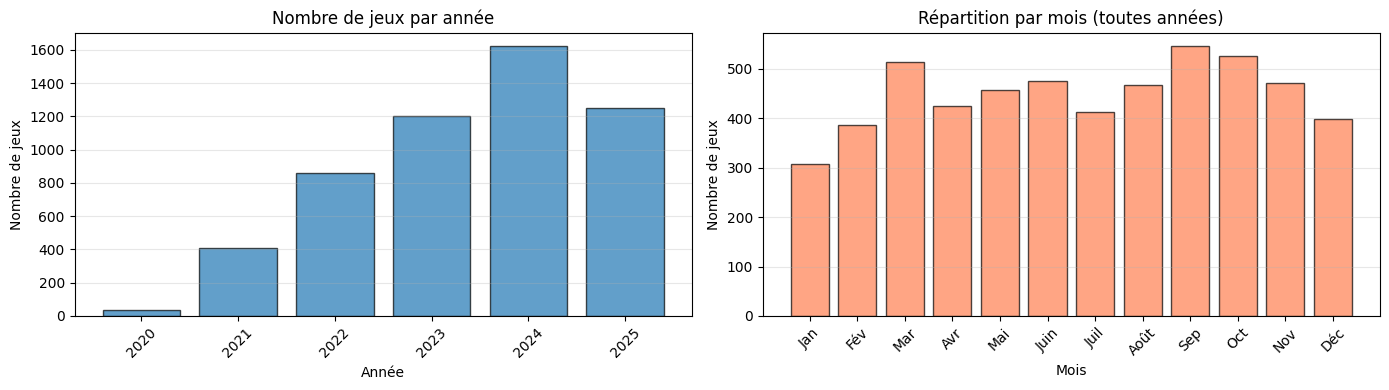

In [411]:
create_plot_analyse_release_dates(df_analyse_release_dates)

## Analyse des genres (aventure, rôle, sport etc.)

In [412]:
df_analyse_genres = df.copy()

In [413]:
def create_plot_histogram_genres_count(df: pd.DataFrame, axe: plt.Axes):
    # Séparer les genres et exploser
    genres_exploded = df["genres"].str.split(",").explode()
    genres_exploded = genres_exploded.str.strip()
    genre_counts = genres_exploded.value_counts()

    axe.bar(
        range(len(genre_counts)),
        genre_counts.values,
        color="steelblue",
        edgecolor="black",
        alpha=0.7,
    )

    axe.set_xticks(range(len(genre_counts)))
    axe.set_xticklabels(genre_counts.index, rotation=45, ha="right")

    axe.set_xlabel("Genre")
    axe.set_ylabel("Nombre de jeux")

In [414]:
def create_plot_analyse_genres(df: pd.DataFrame):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1: plt.Axes
    ax2: plt.Axes

    data = generate_multi_str_col_top_proportion_data(df, "genres", top_count=11)
    draw_binary_circular_plots(
        data,
        "",
        ax1,
    )

    create_plot_histogram_genres_count(df, ax2)

    fig.suptitle(
        "Analyse des genres (un jeu peut avoir plusieurs genres)",
        fontsize=16,
        fontweight="bold",
    )

    plt.tight_layout(pad=2.0)
    plt.show()

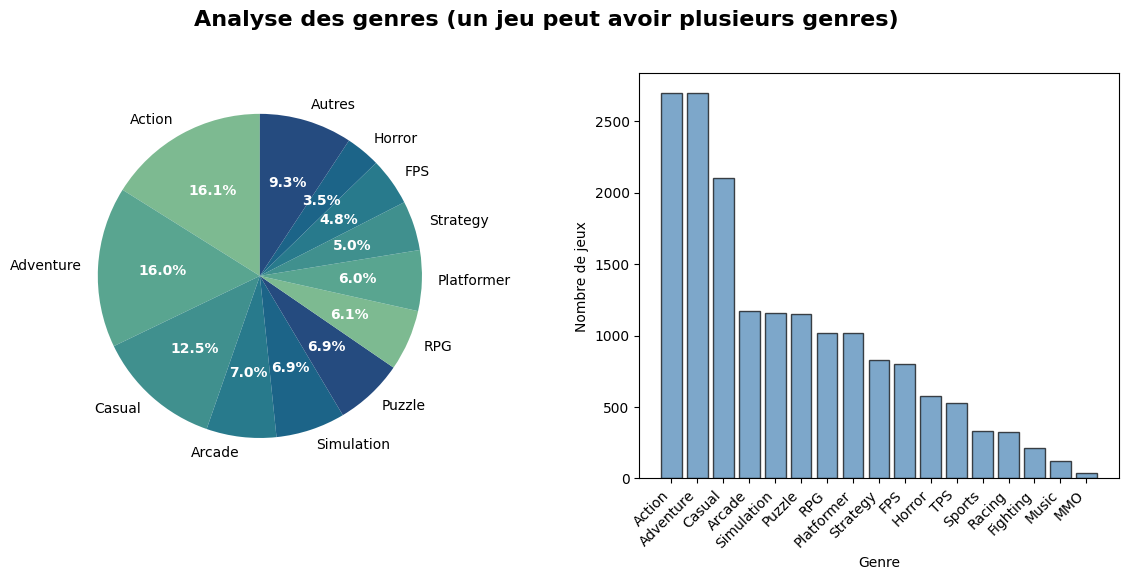

In [415]:
create_plot_analyse_genres(df_analyse_genres)

## Analyse plateformes

In [416]:
df_analyse_plateformes = df.copy()

In [417]:
def generate_platform_proportion_data(df: pd.DataFrame):
    result = [
        {
            "label": "PS4 et PS5",
            "value": ((df["is_ps4"] == 1) & (df["is_ps5"] == 1)).sum(),
        },
        {
            "label": "PS4 Only",
            "value": ((df["is_ps4"] == 1) & (df["is_ps5"] == 0)).sum(),
        },
        {
            "label": "PS5 Only",
            "value": ((df["is_ps4"] == 0) & (df["is_ps5"] == 1)).sum(),
        },
    ]

    return result

In [418]:
def create_plot_histogram_plateformes_count(data,axe: plt.Axes):

    values = [item["value"] for item in data]
    labels = [item["label"] for item in data]

    axe.bar(
        range(len(labels)),
        values,
        color="steelblue",
        edgecolor="black",
        alpha=0.7,
    )

    axe.set_xticks(range(len(labels)))
    axe.set_xticklabels(labels, rotation=45, ha="right")

    axe.set_xlabel("Plateformes")
    axe.set_ylabel("Nombre de jeux")

In [419]:
def create_plot_analyse_plateformes(df: pd.DataFrame):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1: plt.Axes
    ax2: plt.Axes

    data = generate_platform_proportion_data(df)
    draw_binary_circular_plots(
        data,
        "",
        ax1,
    )

    create_plot_histogram_plateformes_count(data, ax2)

    fig.suptitle(
        "Analyse des plateformes",
        fontsize=16,
        fontweight="bold",
    )

    plt.tight_layout(pad=2.0)
    plt.show()

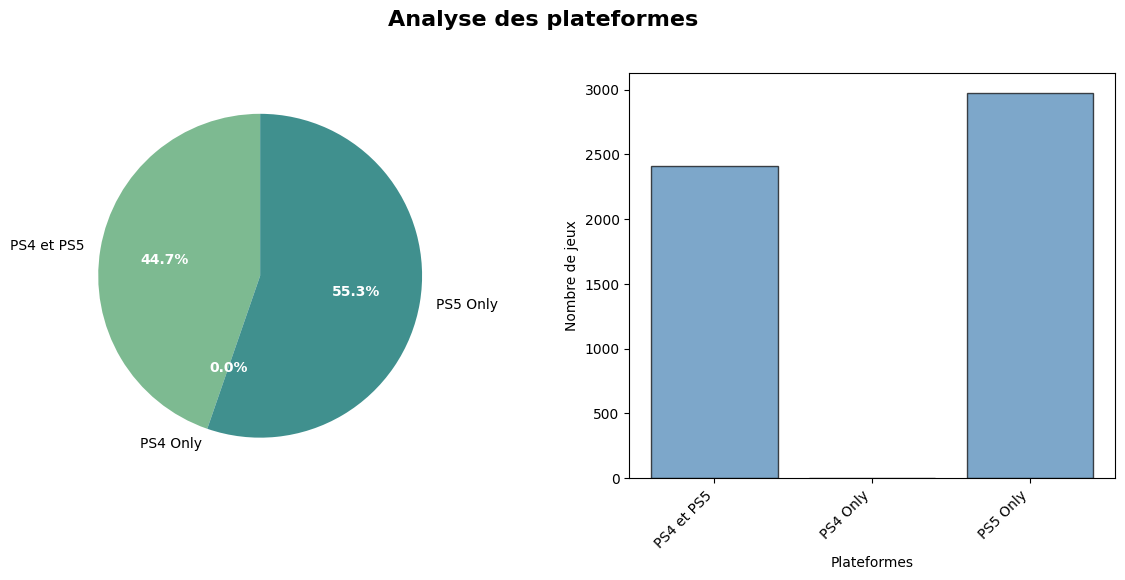

In [420]:
create_plot_analyse_plateformes(df_analyse_plateformes)

## Analyse publisher / developer

In [421]:
# TODO Transformer éditeur
df_analyse_publisher_dev = df.copy()

In [422]:
publisher_counts = df_analyse_publisher_dev['publisher'].value_counts().head(10)

In [423]:
def analyze_top_publishers(df, top_n=15):
    fig, ax = plt.subplots(figsize=(12, 6))
    
    publisher_counts = df['publisher'].value_counts().head(top_n)
    
    sns.barplot(x=publisher_counts.values, y=publisher_counts.index, palette='viridis', ax=ax)
    ax.set_xlabel('Nombre de jeux', fontsize=12)
    ax.set_ylabel('Publisher', fontsize=12)
    ax.set_title(f'Top {top_n} Publishers par nombre de jeux', fontsize=14, fontweight='bold')
    
    # Ajouter les valeurs sur les barres
    for i, v in enumerate(publisher_counts.values):
        ax.text(v + 1, i, str(v), va='center', fontsize=10)
    
    plt.tight_layout()

    return publisher_counts

/tmp/ipykernel_11898/685109195.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=publisher_counts.values, y=publisher_counts.index, palette='viridis', ax=ax)


publisher
eastasiasoft                      253
ratalaika games                   230
ocean media                       133
thigames                          125
smobile                           106
sony interactive entertainment     94
evgeniy kolpakov                   77
nostra games                       75
zakym                              73
kemco                              65
gametry                            65
afil games                         64
jandusoft                          62
bandai namco entertainment         58
nacon                              56
Name: count, dtype: int64

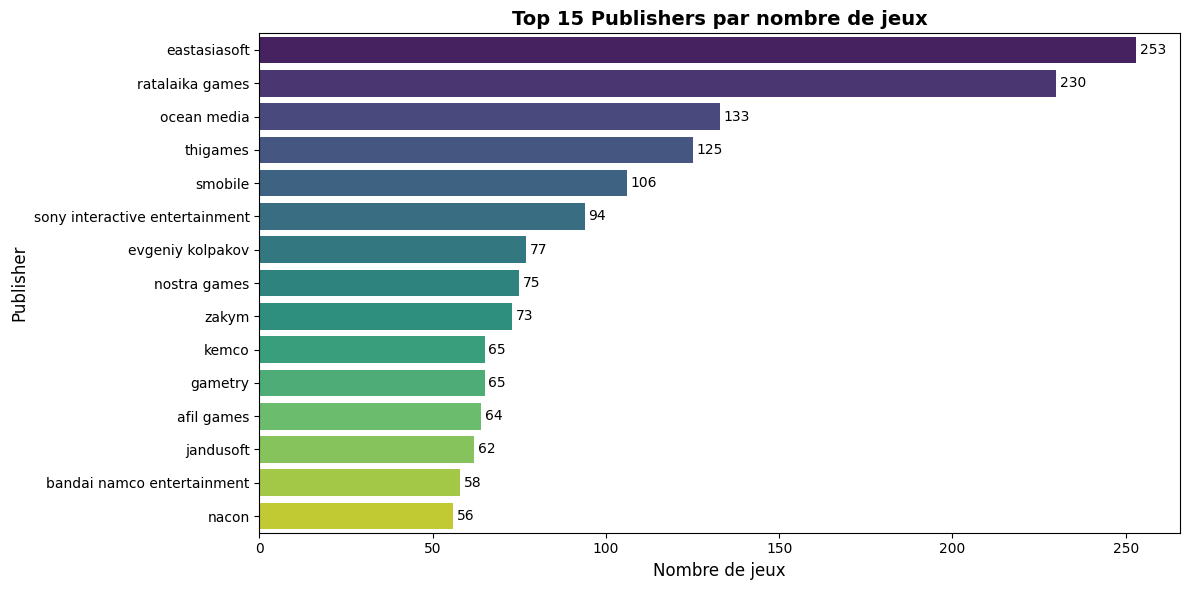

In [424]:
analyze_top_publishers(df_analyse_publisher_dev)

In [425]:
def analyze_publisher_price_range(df:pd.DataFrame, top_n=10):
    df_priced = df[df['base_price'].notna()].copy()
    
    # Top publishers par nombre de jeux
    top_publishers = df_priced['publisher'].value_counts().head(top_n).index
    df_top = df_priced[df_priced['publisher'].isin(top_publishers)]
    
    fig, ax = plt.subplots(figsize=(14, 7))
    
    sns.boxplot(data=df_top, y='publisher', x='base_price', 
                palette='Set2', ax=ax)
    ax.set_xlabel('Prix de base (euro)', fontsize=12)
    ax.set_ylabel('Publisher', fontsize=12)
    ax.set_title(f'Distribution des prix par publisher (Top {top_n})', 
                 fontsize=14, fontweight='bold')
    
    plt.tight_layout()

/tmp/ipykernel_11898/4012849994.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_top, y='publisher', x='base_price',


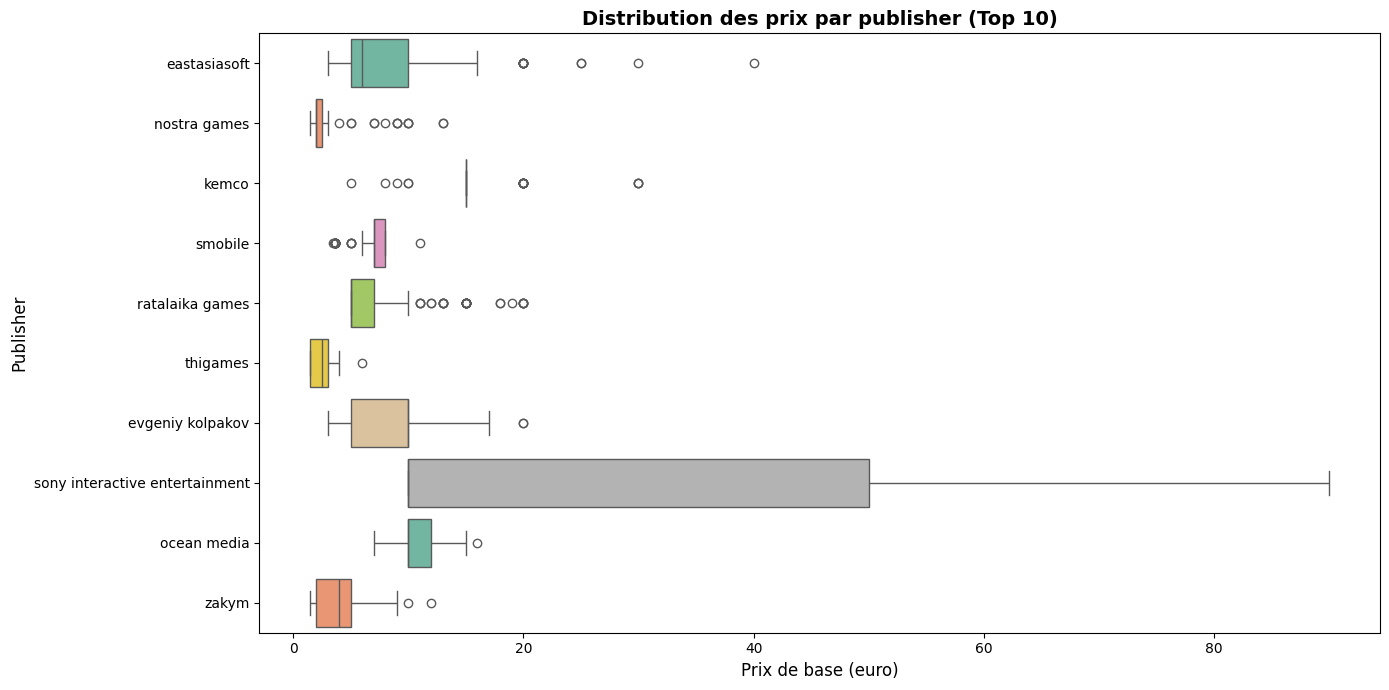

In [426]:
analyze_publisher_price_range(df_analyse_publisher_dev)

## Analyse des séries

In [427]:
df_analyse_series = df.copy()

In [428]:
total_games = len(df_analyse_series)
games_in_series = (df_analyse_series['series_count'] > 0).sum()
pct_in_series = games_in_series / total_games * 100

print(f"\nJeux totaux: {total_games}")

print(f"Jeux faisant partie d'une série (series_count > 0): {games_in_series} ({pct_in_series:.1f}%)")
print(f"Jeux standalone (series_count = 0): {total_games - games_in_series} ({100-pct_in_series:.1f}%)")

df_series = df[df['series_count'] > 0]

print(f"\nTaille moyenne des séries: {df_series['series_count'].mean():.1f}")
print(f"Taille médiane des séries: {df_series['series_count'].median():.0f}")
print(f"Plus grande série: {df_series['series_count'].max()} jeux")


Jeux totaux: 5382
Jeux faisant partie d'une série (series_count > 0): 610 (11.3%)
Jeux standalone (series_count = 0): 4772 (88.7%)

Taille moyenne des séries: 7.7
Taille médiane des séries: 5
Plus grande série: 38 jeux


In [429]:
def analyze_series_distribution(df:pd.DataFrame):
    fig, (ax) = plt.subplots(1, 1, figsize=(16, 6))
    
    ax:plt.Axes
    
    # Graphique 2: Focus sur series_count > 0
    df_series = df[df['series_count'] > 0]
    series_dist_filtered = df_series['series_count'].value_counts().sort_index()
    ax.bar(series_dist_filtered.index, series_dist_filtered.values, color='coral', alpha=0.7)
    ax.set_xlabel('Nombre de jeux dans la série', fontsize=12)
    ax.set_ylabel('Nombre de jeux', fontsize=12)
    ax.set_title('Distribution de series_count (> 0 uniquement)', fontsize=14, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()

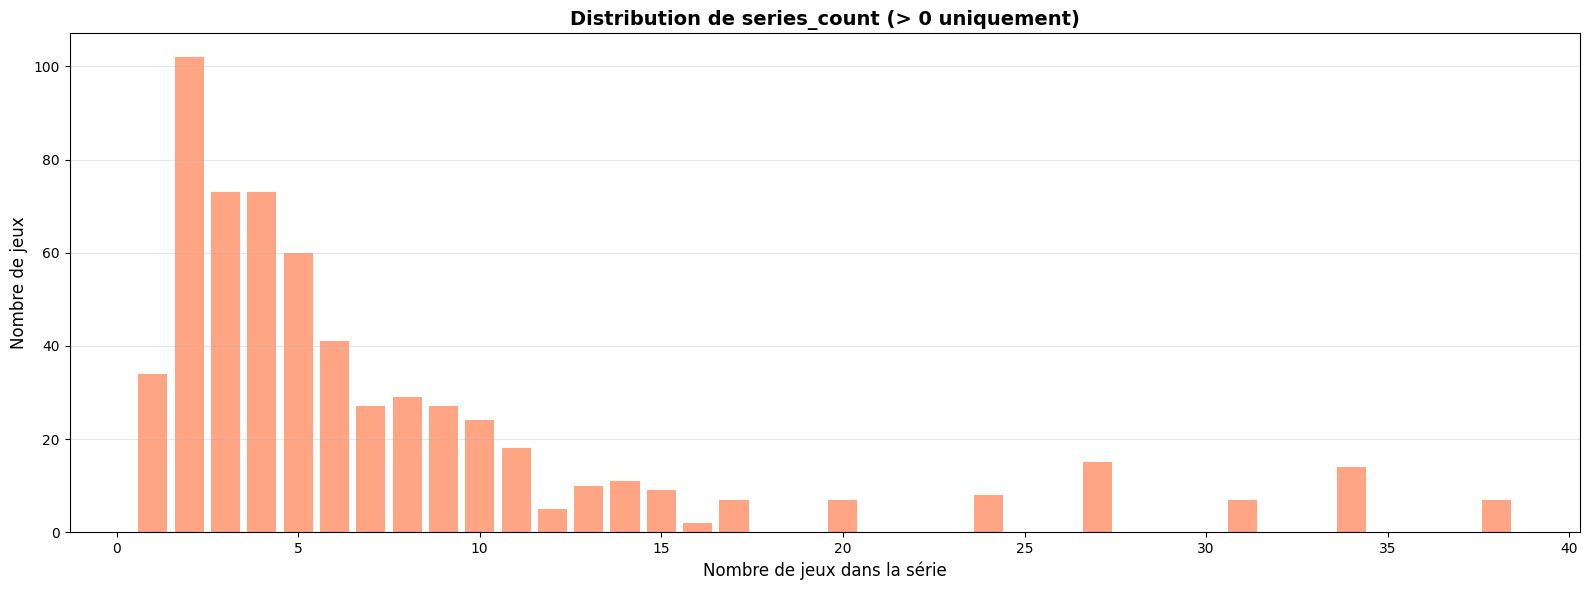

In [430]:
analyze_series_distribution(df_analyse_series)

## Analyse DLCS

In [431]:
df_analyse_dlcs = df.copy()

In [432]:
df_analyse_dlcs['has_dlcs'] = df_analyse_dlcs['dlcs_count'] > 0
total = len(df_analyse_dlcs)
with_dlcs = df_analyse_dlcs['has_dlcs'].sum()
with_mt = (df_analyse_dlcs['has_microtransactions'] == 1).sum()

print(f"Jeux avec DLCs: {with_dlcs} ({with_dlcs/total*100:.1f}%)")
print(f"Jeux sans DLCs: {total - with_dlcs} ({(total-with_dlcs)/total*100:.1f}%)")

df_dlcs = df_analyse_dlcs[df_analyse_dlcs['has_dlcs']]
print(f"\nNombre moyen de DLCs (quand présents): {df_dlcs['dlcs_count'].mean():.1f}")
print(f"Nombre médian de DLCs: {df_dlcs['dlcs_count'].median():.0f}")

Jeux avec DLCs: 868 (16.1%)
Jeux sans DLCs: 4514 (83.9%)

Nombre moyen de DLCs (quand présents): 7.6
Nombre médian de DLCs: 3


In [433]:
def analyze_publishers_dlc_mt(df:pd.DataFrame, top_n=10):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Top publishers par nombre de DLCs
    df_with_dlcs = df[df['has_dlcs']].copy()
    pub_dlc = df_with_dlcs['publisher'].value_counts().head(top_n)
    
    sns.barplot(y=pub_dlc.index, x=pub_dlc.values, palette='Blues_r', ax=ax1)
    ax1.set_xlabel('Nombre de jeux avec DLCs', fontsize=12)
    ax1.set_ylabel('Publisher', fontsize=12)
    ax1.set_title(f'Top {top_n} Publishers - Jeux avec DLCs', fontsize=14, fontweight='bold')
    
    for i, v in enumerate(pub_dlc.values):
        ax1.text(v + 1, i, str(v), va='center', fontsize=10)
    
    # Top publishers par microtransactions
    df_with_mt = df[df['has_microtransactions'] == 1].copy()
    pub_mt = df_with_mt['publisher'].value_counts().head(top_n)
    
    sns.barplot(y=pub_mt.index, x=pub_mt.values, palette='Reds_r', ax=ax2)
    ax2.set_xlabel('Nombre de jeux avec microtransactions', fontsize=12)
    ax2.set_ylabel('Publisher', fontsize=12)
    ax2.set_title(f'Top {top_n} Publishers - Microtransactions', fontsize=14, fontweight='bold')
    
    for i, v in enumerate(pub_mt.values):
        ax2.text(v + 0.5, i, str(v), va='center', fontsize=10)
    
    plt.tight_layout()

/tmp/ipykernel_11898/2142241432.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=pub_dlc.index, x=pub_dlc.values, palette='Blues_r', ax=ax1)
/tmp/ipykernel_11898/2142241432.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=pub_mt.index, x=pub_mt.values, palette='Reds_r', ax=ax2)


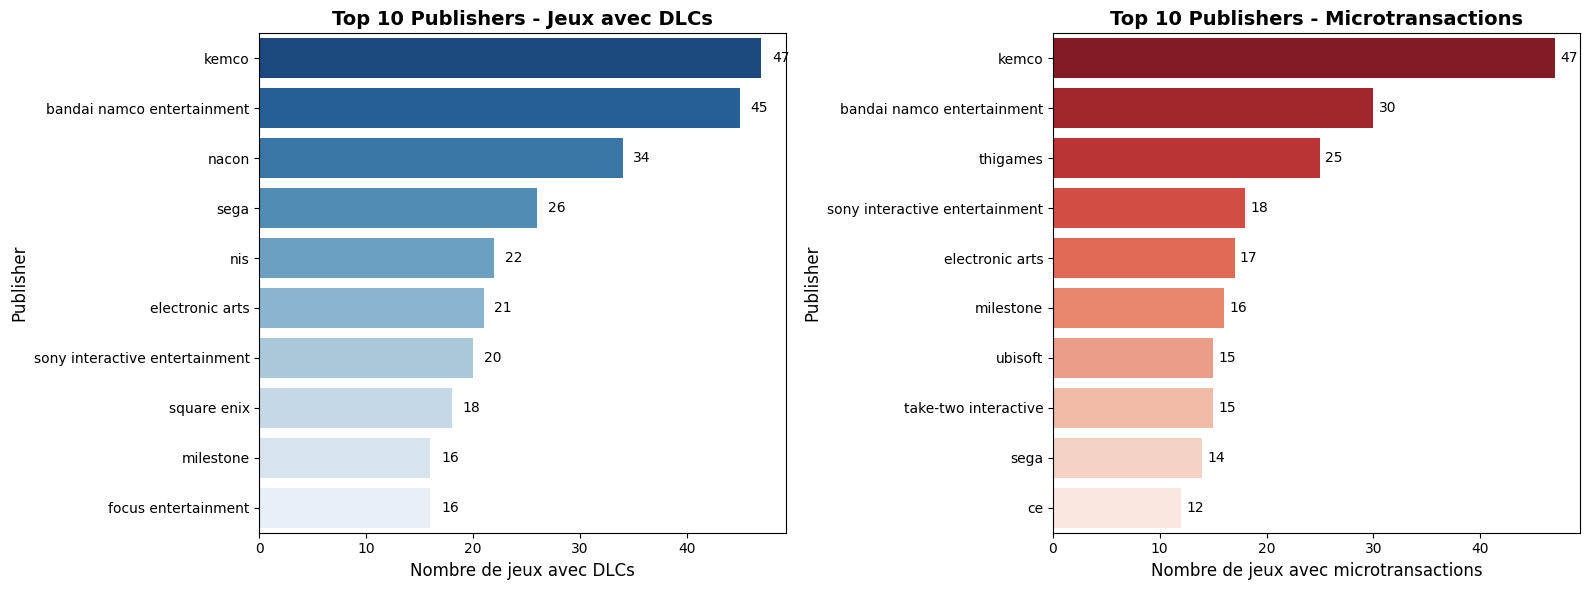

In [434]:
analyze_publishers_dlc_mt(df_analyse_dlcs)

## Analyse données contenus

In [435]:
df_analyse_content = df.copy()

In [436]:
df_analyse_content['download_size_gb'] = df_analyse_content['download_size'] / (1024**3)
df_analyse_content['voice_count'] = df_analyse_content['voice_languages'].apply(lambda x: len(str(x).split(',')) if pd.notna(x) else 0)
df_analyse_content['subtitle_count'] = df_analyse_content['subtitle_languages'].apply(lambda x: len(str(x).split(',')) if pd.notna(x) else 0)

In [437]:
def print_summary_stats(df:pd.DataFrame):
    print("STATISTIQUES - CONTENU DES JEUX")

    print("\nHEURES DE COMPLETION")
    
    print(f"Histoire principale: {df['hours_main_story'].mean():.1f}h (moy) | "
          f"{df['hours_main_story'].median():.0f}h (méd) | {df['hours_main_story'].max():.0f}h (max)")
    print(f"Completionist: {df['hours_completionist'].mean():.1f}h (moy) | "
          f"{df['hours_completionist'].median():.0f}h (méd) | {df['hours_completionist'].max():.0f}h (max)")
    
    print("\nLANGUES")
    print(f"Voix: {df['voice_count'].mean():.1f} langues en moyenne")
    print(f"Sous-titres: {df['subtitle_count'].mean():.1f} langues en moyenne")
    print(f"Jeux avec voix: {(df['voice_count'] > 0).sum()} ({(df['voice_count'] > 0).sum()/len(df)*100:.1f}%)")
    print(f"Jeux avec sous-titres: {(df['subtitle_count'] > 0).sum()} ({(df['subtitle_count'] > 0).sum()/len(df)*100:.1f}%)")
    
    print("\nTROPHEES")
    print(f"Moyenne: {df['trophies_count'].mean():.1f} | Médiane: {df['trophies_count'].median():.0f}")
    print(f"Jeux sans trophées: {(df['trophies_count'] == 0).sum()}")
    
    print("\nTAILLE TELECHARGEMENT")
    print(f"Moyenne: {df['download_size_gb'].mean():.1f} GB | Médiane: {df['download_size_gb'].median():.1f} GB")
    print(f"Max: {df['download_size_gb'].max():.1f} GB")
    
    print("\nDIFFICULTE")
    df_diff = df[df['difficulty'].notna()]
    print(f"Moyenne: {df_diff['difficulty'].mean():.1f}")
    print(f"Distribution: Facile ({(df_diff['difficulty'] <= 3).sum()}) | "
          f"Moyen ({((df_diff['difficulty'] > 3) & (df_diff['difficulty'] <= 7)).sum()}) | "
          f"Difficile ({(df_diff['difficulty'] > 7).sum()})")

In [438]:
print_summary_stats(df_analyse_content)

STATISTIQUES - CONTENU DES JEUX

HEURES DE COMPLETION
Histoire principale: 10.3h (moy) | 5h (méd) | 1000h (max)
Completionist: 11.5h (moy) | 5h (méd) | 1500h (max)

LANGUES
Voix: 1.0 langues en moyenne
Sous-titres: 4.1 langues en moyenne
Jeux avec voix: 2561 (47.6%)
Jeux avec sous-titres: 3762 (69.9%)

TROPHEES
Moyenne: 28.0 | Médiane: 24
Jeux sans trophées: 25

TAILLE TELECHARGEMENT
Moyenne: 5.9 GB | Médiane: 0.8 GB
Max: 137.8 GB

DIFFICULTE
Moyenne: 3.4
Distribution: Facile (1656) | Moyen (464) | Difficile (307)


In [439]:
def analyze_difficulty(df:pd.DataFrame):

    fig, (ax1) = plt.subplots(1, 1, figsize=(16, 6))
    ax1: plt.Axes


    df_diff = df[df['difficulty'].notna()].copy()
    
    # Distribution
    diff_dist = df_diff['difficulty'].value_counts().sort_index()
    
    colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(diff_dist)))
    bars = ax1.bar(diff_dist.index, diff_dist.values, color=colors, alpha=0.7, edgecolor='black')
    ax1.set_xlabel('Niveau de difficulté', fontsize=12)
    ax1.set_ylabel('Nombre de jeux', fontsize=12)
    ax1.set_title('Distribution de la difficulté', fontsize=14, fontweight='bold')
    ax1.grid(axis='y', alpha=0.3)
    
    for bar, val in zip(bars, diff_dist.values):
        ax1.text(bar.get_x() + bar.get_width()/2, val + 5, str(val),
                ha='center', fontsize=9)
    
    plt.tight_layout()

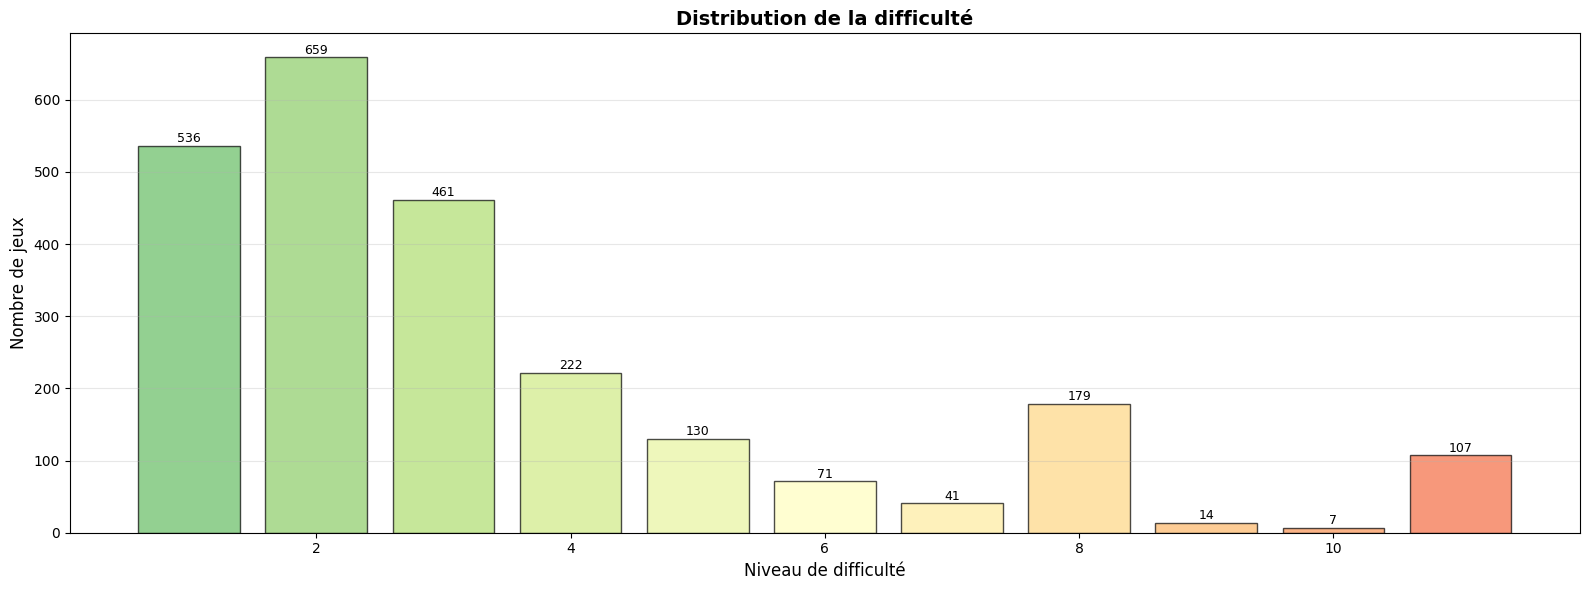

In [440]:
analyze_difficulty(df_analyse_content)

In [441]:
def analyze_download_size(df:pd.DataFrame):
    fig, (ax1) = plt.subplots(1, 1, figsize=(16, 6))
    
    ax1:plt.Axes
    
    df_size = df[df['download_size_gb'].notna() & (df['download_size_gb'] > 0)].copy()
    
    # Par catégorie
    bins = [0, 1, 5, 10, 25, 50, 150]
    labels = ['<1 GB', '1-5 GB', '5-10 GB', '10-25 GB', '25-50 GB', '>50 GB']
    df_size['size_category'] = pd.cut(df_size['download_size_gb'], bins=bins, labels=labels)
    
    size_dist = df_size['size_category'].value_counts().reindex(labels, fill_value=0)
    colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(labels)))
    
    bars = ax1.bar(range(len(size_dist)), size_dist.values, color=colors, alpha=0.7, edgecolor='black')
    ax1.set_xticks(range(len(size_dist)))
    ax1.set_xticklabels(labels, rotation=45, ha='right')
    ax1.set_ylabel('Nombre de jeux', fontsize=12)
    ax1.set_title('Répartition par catégorie de taille', fontsize=14, fontweight='bold')
    ax1.grid(axis='y', alpha=0.3)
    
    for bar, val in zip(bars, size_dist.values):
        ax1.text(bar.get_x() + bar.get_width()/2, val + 5, str(val),
                ha='center', fontsize=10)
    
    plt.tight_layout()

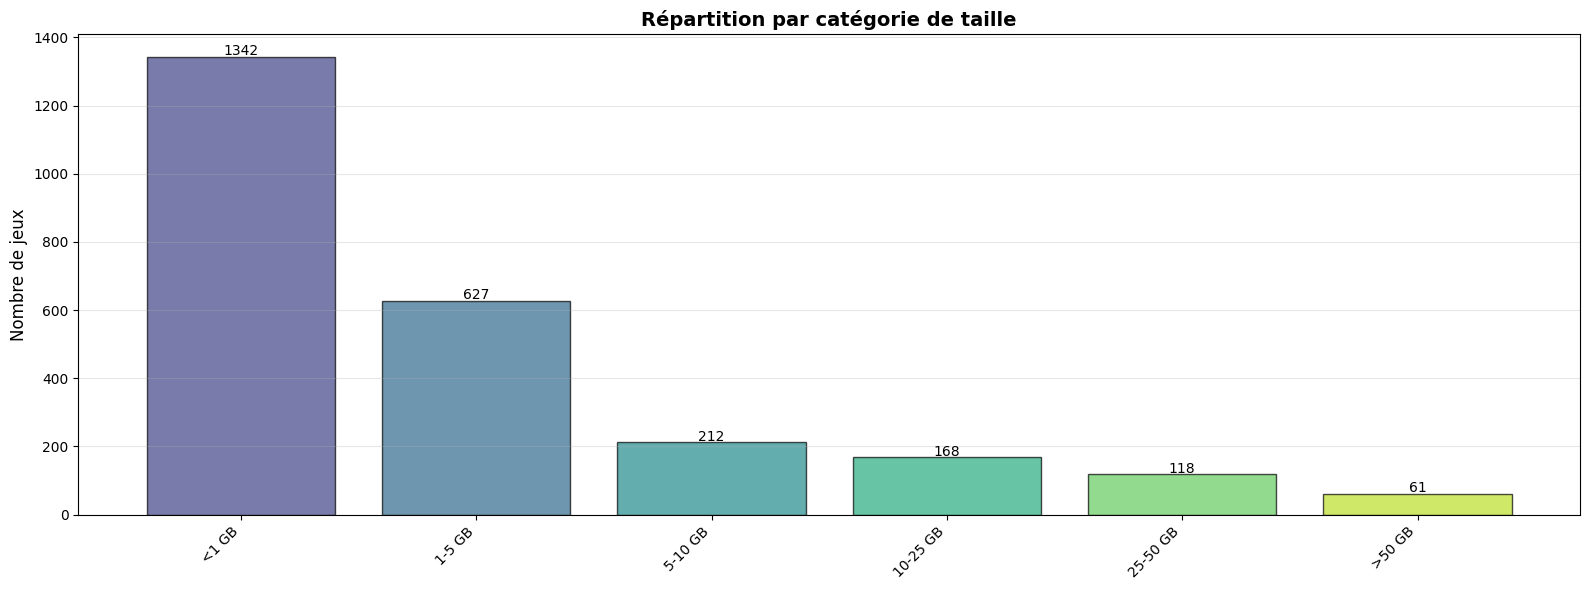

In [442]:
analyze_download_size(df_analyse_content)

## Analyse popularité / score

In [443]:
df_analyse_score_pop = df.copy()

In [444]:
def print_score_pop_summary_stats(df:pd.DataFrame):
  
    print("\nPSSTORE Rating")
    print(f"Note moyenne: {df['pssstore_stars_rating'].mean():.2f}/5")
    print(f"Note médiane: {df['pssstore_stars_rating'].median():.2f}/5")
    print(f"Votes moyens: {df['pssstore_stars_rating_count'].mean():.0f}")
    print(f"Votes médians: {df['pssstore_stars_rating_count'].median():.0f}")
    
    print("\n--- METACRITIC ---")
    df_meta = df[df['metacritic_critic_score'].notna()]
    if len(df_meta) > 0:
        print(f"Critic Score moyen: {df_meta['metacritic_critic_score'].mean():.1f}/100")
        print(f"User Score moyen: {df_meta['metacritic_critic_userscore'].mean():.1f}/100")
        print(f"Couverture: {len(df_meta)} jeux ({len(df_meta)/len(df)*100:.1f}%)")
    
    print("\nTOP 10 Nombre de votes")
    top_pop = df.nlargest(10, 'pssstore_stars_rating_count')[['game_name', 'pssstore_stars_rating_count', 'pssstore_stars_rating']]
    for idx, row in top_pop.iterrows():
        print(f"  {row['game_name'][:40]}: {row['pssstore_stars_rating_count']:.0f} votes ({row['pssstore_stars_rating']:.2f}/5)")
    
    print("\nTOP 5 MIEUX NOTÉS (≥100 votes)")
    df_rated = df[df['pssstore_stars_rating_count'] >= 100]
    top_rated = df_rated.nlargest(5, 'pssstore_stars_rating')[['game_name', 'pssstore_stars_rating', 'pssstore_stars_rating_count']]
    for idx, row in top_rated.iterrows():
        print(f"  {row['game_name'][:40]}: {row['pssstore_stars_rating']:.2f}/5 ({row['pssstore_stars_rating_count']:.0f} votes)")


In [445]:
print_score_pop_summary_stats(df_analyse_score_pop)


PSSTORE Rating
Note moyenne: 3.86/5
Note médiane: 4.00/5
Votes moyens: 3502
Votes médians: 88

--- METACRITIC ---
Critic Score moyen: 57.9/100
User Score moyen: 59.1/100
Couverture: 1268 jeux (23.6%)

TOP 10 Nombre de votes
  Minecraft: 1825682 votes (4.30/5)
  Grand Theft Auto Online (PlayStation®5): 864954 votes (4.48/5)
  Grand Theft Auto V (PS4™ & PS5™): 864616 votes (4.48/5)
  Call of Duty®: Modern Warfare® II - Pack: 612373 votes (3.96/5)
  Call of Duty®: Modern Warfare® III - Pac: 612214 votes (3.96/5)
  Call of Duty®: Black Ops 6 - Pack Cross-: 612117 votes (3.96/5)
  Ghost of Tsushima: Legends: 278130 votes (4.60/5)
  Ghost of Tsushima DIRECTOR'S CUT: 277541 votes (4.60/5)
  The Witcher 3: Wild Hunt: 265589 votes (4.83/5)
  DRAGON BALL XENOVERSE 2: 251990 votes (3.87/5)

TOP 5 MIEUX NOTÉS (≥100 votes)
  Sly 2: Band of Thieves™: 4.94/5 (8384 votes)
  Sly 3: Honour Among Thieves™: 4.94/5 (6296 votes)
  Dispatch: 4.92/5 (1949 votes)
  Hidden Cats in Spooky Town: 4.91/5 (257 vote

## Analyse public Ciblé / PEGI / ESRB Rating

In [446]:
df_analyse_rating_target = df.copy()

In [447]:
from collections import Counter

def print_summary_pegi_stats(df:pd.DataFrame):    
    print("\nPEGI")
    df_pegi = df[df['pegi_rating'].notna()]
    pegi_counts = df_pegi['pegi_rating'].value_counts().sort_index()
    for rating, count in pegi_counts.items():
        pct = count / len(df_pegi) * 100
        print(f"  PEGI {int(rating)}: {count} jeux ({pct:.1f}%)")
    
    print("\nESRB")
    df_esrb = df[df['esrb_rating'].notna()]
    esrb_counts = df_esrb['esrb_rating'].value_counts()
    for rating, count in esrb_counts.items():
        pct = count / len(df_esrb) * 100
        print(f"  {rating}: {count} jeux ({pct:.1f}%)")
    
    print("\nCONTENU (Top 10)")
    all_descriptions = []
    for desc in df['rating_descriptions'].dropna():
        all_descriptions.extend([d.strip() for d in str(desc).split(',')])
    desc_counts = Counter(all_descriptions)
    for desc, count in desc_counts.most_common(10):
        print(f"  {desc}: {count}")

In [448]:
print_summary_pegi_stats(df_analyse_rating_target)


PEGI
  PEGI 3: 1700 jeux (37.3%)
  PEGI 7: 904 jeux (19.8%)
  PEGI 12: 832 jeux (18.2%)
  PEGI 16: 829 jeux (18.2%)
  PEGI 18: 297 jeux (6.5%)

ESRB
  Everyone: 2057 jeux (38.4%)
  Teen: 1428 jeux (26.7%)
  Everyone 10+: 1025 jeux (19.1%)
  Mature 17+: 636 jeux (11.9%)
  Adults Only 18+: 212 jeux (4.0%)

CONTENU (Top 10)
  Violence: 2541
  Fantasy Violence: 1816
  Blood: 1451
  Language: 1009
  Bad Language: 793
  Suggestive Themes: 569
  Strong Language: 544
  Blood and Gore: 477
  In-Game Purchases: 439
  Users Interact: 409


In [449]:
def analyze_rating_vs_price(df:pd.DataFrame):

    df_priced = df[(df['base_price'].notna()) & (df['base_price'] > 0)].copy()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Prix moyen par PEGI
    df_pegi = df_priced[df_priced['pegi_rating'].notna()].copy()
    pegi_price = df_pegi.groupby('pegi_rating')['base_price'].mean()
    
    colors = ['#4caf50', '#8bc34a', '#ffc107', '#ff9800', '#f44336']
    bars = ax1.bar(pegi_price.index, pegi_price.values, color=colors,
                   alpha=0.7, edgecolor='black', width=1.5)
    ax1.set_xlabel('PEGI Rating', fontsize=12)
    ax1.set_ylabel('Prix moyen (E)', fontsize=12)
    ax1.set_title('Prix moyen par PEGI Rating', fontsize=14, fontweight='bold')
    ax1.set_xticks([3, 7, 12, 16, 18])
    ax1.grid(axis='y', alpha=0.3)
    
    for bar, val in zip(bars, pegi_price.values):
        ax1.text(bar.get_x() + bar.get_width()/2, val + 0.5, f'{val:.2f}',
                ha='center', fontsize=11, fontweight='bold')
    
    # Prix moyen par ESRB
    df_esrb = df_priced[df_priced['esrb_rating'].notna()].copy()
    esrb_price = df_esrb.groupby('esrb_rating')['base_price'].mean()
    esrb_order = ['Everyone', 'Everyone 10+', 'Teen', 'Mature 17+', 'Adults Only 18+']
    esrb_price = esrb_price.reindex(esrb_order)
    
    bars = ax2.bar(range(len(esrb_price)), esrb_price.values, color=colors,
                   alpha=0.7, edgecolor='black')
    ax2.set_xticks(range(len(esrb_price)))
    ax2.set_xticklabels(esrb_order, rotation=45, ha='right')
    ax2.set_ylabel('Prix moyen (E)', fontsize=12)
    ax2.set_title('Prix moyen par ESRB Rating', fontsize=14, fontweight='bold')
    ax2.grid(axis='y', alpha=0.3)
    
    for bar, val in zip(bars, esrb_price.values):
        if pd.notna(val):
            ax2.text(bar.get_x() + bar.get_width()/2, val + 0.5, f'{val:.2f}',
                    ha='center', fontsize=11, fontweight='bold')
    
    plt.tight_layout()

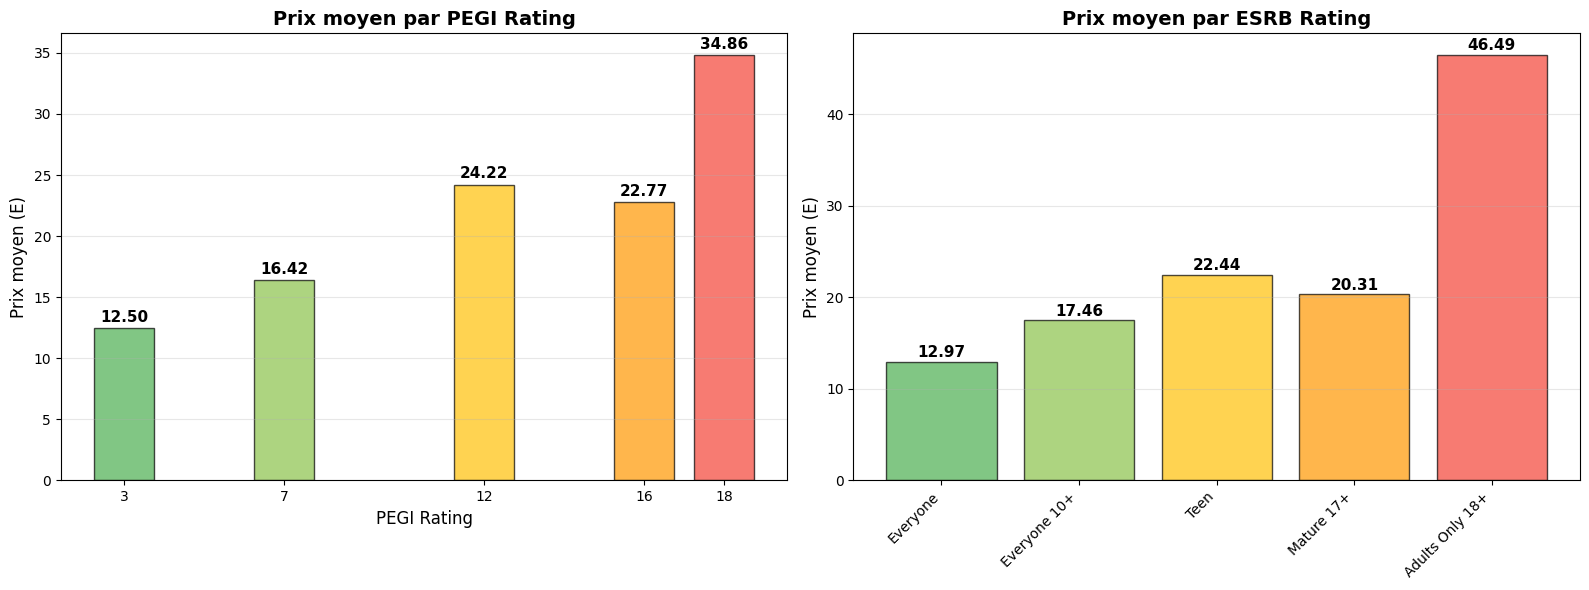

In [450]:
analyze_rating_vs_price(df_analyse_rating_target)

## Analyse des données binaires

In [451]:
df_analyse_binary = df.copy()

In [452]:
def generate_proportion_analyse_plot(df: pd.DataFrame):
    list_cols_true_false = [
        # {"col": "is_dlc", "title": "Catégorie DLC"},
        {"col": "is_indie", "title": "De la catégorie Indie"},
        {"col": "is_vr", "title": "Mode VR disponible"},
        {"col": "is_opti_ps5_pro", "title": "Optimisé PS5 PRO"},
        {"col": "is_ps_exclusive", "title": "Exclusif PlayStation"},
        {"col": "is_remaster", "title": "Remastered"},
        {"col": "has_local_multiplayer", "title": "Mode multi local disponible"},
        {"col": "has_online_multiplayer", "title": "Mode multi en ligne disponible"},
        {"col": "is_online_only", "title": "Jeu en ligne uniquement"},
        {"col": "has_microtransactions", "title": "Microtransactions présentes"},
    ]

    fig, axes = layout_plots(9)

    cpt = 0
    for col_plt in list_cols_true_false:
        data_plt = generate_binary_cols_proportion_data(df, col_plt["col"])
        if data_plt is not None:
            draw_binary_circular_plots(data_plt, col_plt["title"], axes[cpt])
            cpt += 1

    # for j in range(cpt, len(axes)):
    #     axes[j].axis("off")
        
    fig.suptitle(
        f"Analyse des données binaires",
        fontsize=14,
        fontweight="bold",
    )
    plt.show()

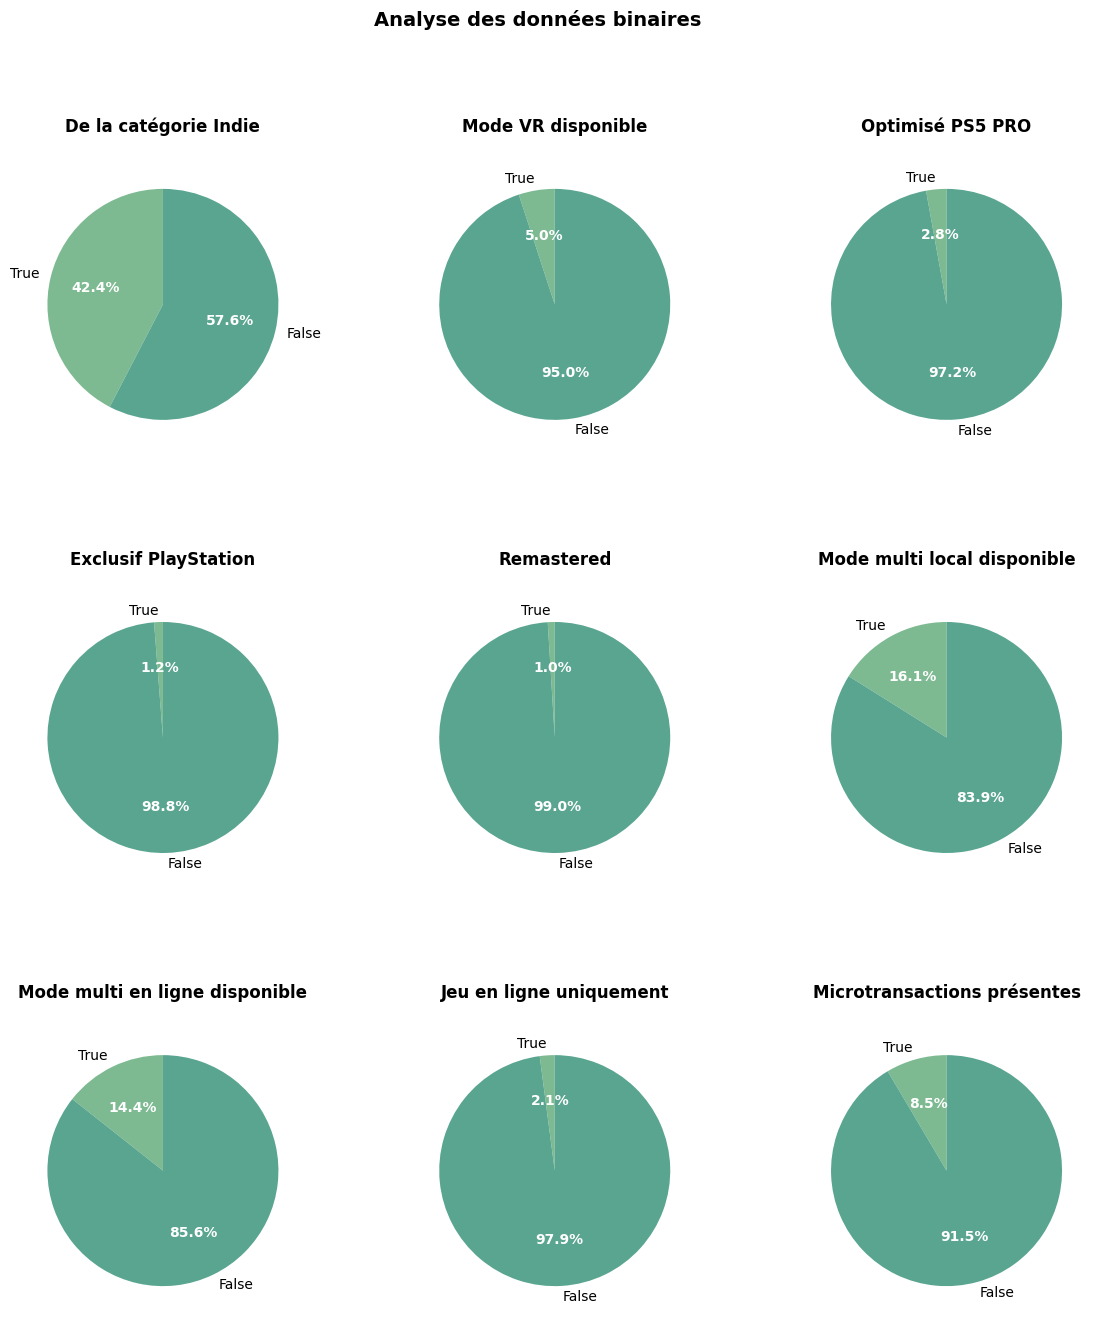

In [453]:
generate_proportion_analyse_plot(df_analyse_binary)

## Analyse des prix de base

In [454]:
df_analyse_base_prices = df.copy()

In [455]:
def generate_base_price_proportion_data(df: pd.DataFrame):
    result = []
    for seg in PRICE_SEGMENTS:
        result.append(
            {
                "label": seg["label"],
                "value": (
                    (df["base_price"] >= seg["value_min"])
                    & (df["base_price"] <= seg["value_max"])
                ).sum(),
            }
        )

    return result

In [456]:
def create_histogram_base_price_frequence(df: pd.DataFrame, axe: plt.Axes):

    counts, bin_edges = np.histogram(df["base_price"], bins=100)
    
    axe.bar(
        bin_edges[:-1],  # Utiliser les bords gauches (sans le dernier)
        counts,
        color="steelblue",
        edgecolor="black",
        alpha=0.7,
        align="center",
    )

    axe.set_xlabel("Prix euro", fontsize=12)
    axe.set_ylabel("Frequence", fontsize=12)
    axe.set_title("Distribution des prix", fontsize=14, fontweight="bold")
    axe.grid(axis="y", alpha=0.3, linestyle="--")
    axe.set_xticks(range(0, 100, 5))
    axe.set_xlim(0, 100)

    # Afficher des statistiques
    mean_price = df["base_price"].mean()
    median_price = df["base_price"].median()

    # Moyenne
    axe.axvline(
        mean_price,
        color="red",
        linestyle="--",
        linewidth=2,
        label=f"Moyenne: {mean_price:.2f}",
    )
    # Mediane
    axe.axvline(
        median_price,
        color="green",
        linestyle="--",
        linewidth=2,
        label=f"Mediane: {median_price:.2f}",
    )
    axe.legend()

In [457]:
def histogram_base_price_unique_count(df: pd.DataFrame, axe: plt.Axes):
    price_counts = df["base_price"].value_counts().sort_index()
    axe.barh(price_counts.index, price_counts.values)
    axe.set_title("Frequence des prix uniques", fontsize=14)
    axe.set_xlabel("Frequence", fontsize=12)
    axe.set_ylabel("Prix", fontsize=12)
    axe.grid(axis="x", alpha=0.3)

In [458]:
def histogram_base_price_unique_count_top(df: pd.DataFrame, axe: plt.Axes):
    # Compter les occurrences et prendre les plus fréquents
    top = df["base_price"].value_counts().head(15).sort_values()

    axe.barh(  # barh au lieu de bar pour horizontal
        range(len(top)),  # Positions sur l'axe y
        top.values,  # Fréquences sur l'axe x
        color="steelblue",
        edgecolor="black",
        alpha=0.7,
    )

    # Configurer les étiquettes de l'axe y avec les valeurs de base_price
    axe.set_yticks(range(len(top)))
    axe.set_yticklabels(top.index)
    axe.set_title("Top 15 des prix les plus fréquents")

In [459]:
def create_plot_analyse_base_prices(df: pd.DataFrame):

    fig = plt.figure(figsize=(12, 8))

    # Première ligne : 1 graphique qui prend toute la largeur
    ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)

    # Deuxième ligne : 2 graphiques
    ax2 = plt.subplot2grid((2, 2), (1, 0))
    ax3 = plt.subplot2grid((2, 2), (1, 1))

    create_histogram_base_price_frequence(df, ax1)

    data_price = generate_base_price_proportion_data(df)
    draw_binary_circular_plots(data_price, "", ax2)

    histogram_base_price_unique_count_top(df, ax3)

    plt.tight_layout()
    plt.show()

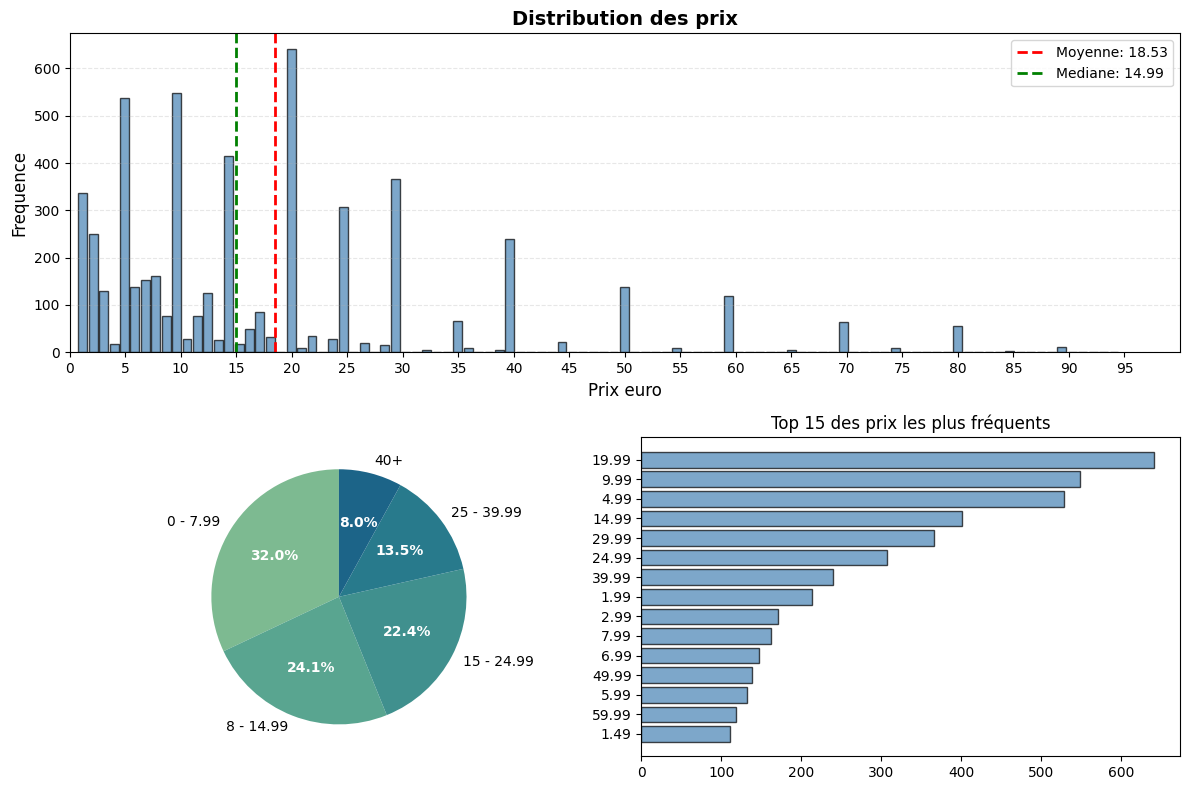

In [460]:
create_plot_analyse_base_prices(df_analyse_base_prices)

## Analyse historique baisse de prix / promos

In [461]:
df_analyse_prices_history = df.copy()

In [462]:
# Convertir la colonne price_history de JSON vers list
df_analyse_prices_history['price_history'] = df_analyse_prices_history['price_history'].apply(
    lambda x: json.loads(x) if isinstance(x, str) else x
)

In [463]:
def analyse_price_history_get_oldest_date(price_history):
    if not price_history or len(price_history) == 0:
        return None
    try:
        dates = [datetime.strptime(entry['x'], "%Y-%m-%d") for entry in price_history]
        return min(dates) if dates else None
    except:
        return None

def analyse_price_history_get_newest_date(price_history):
    if not price_history or len(price_history) == 0:
        return None
    try:
        dates = [datetime.strptime(entry['x'], "%Y-%m-%d") for entry in price_history]
        return max(dates) if dates else None
    except:
        return None
    
    
def analyse_price_history_count_price_drops(price_history):
    if not price_history or len(price_history) < 2:
        return 0
    
    try:
        # Trier par date
        sorted_history = sorted(price_history, key=lambda x: x['x'])
        prices = [entry['y'] for entry in sorted_history if entry['y'] >= 0.1]
        
        if len(prices) < 2:
            return 0
        
        # Compter les baisses
        drops = 0
        for i in range(1, len(prices)):
            if prices[i] < prices[i-1]:
                drops += 1
        
        return drops
    except:
        return 0
    
def analyse_price_history_get_price_range(price_history):
    if not price_history or len(price_history) == 0:
        return None
    try:
        prices = [entry['y'] for entry in price_history if entry['y'] >= 0.1]
        if not prices:
            return None
        return max(prices) - min(prices)
    except:
        return None

def analyse_price_history_get_max_discount_percent(price_history, base_price):
    if not price_history or len(price_history) == 0 or not base_price or base_price <= 0:
        return None
    try:
        prices = [entry['y'] for entry in price_history if entry['y'] >= 0.1]
        if not prices:
            return None
        min_price = min(prices)
        return ((base_price - min_price) / base_price) * 100
    except:
        return None
    
def analyse_price_history_get_avg_days_between_updates(price_history):
    if not price_history or len(price_history) < 2:
        return None
    try:
        dates = sorted([datetime.strptime(entry['x'], "%Y-%m-%d") for entry in price_history])
        if len(dates) < 2:
            return None
        
        intervals = [(dates[i+1] - dates[i]).days for i in range(len(dates)-1)]
        return sum(intervals) / len(intervals) if intervals else None
    except:
        return None
    
def analyse_price_history_has_valid_data(price_history):
    if not price_history or len(price_history) == 0:
        return False
    try:
        for entry in price_history:
            if 'x' not in entry or 'y' not in entry:
                return False
            if entry['y'] < 0:
                return False
        return True
    except:
        return False
    
def analyse_price_history_has_zero_prices(price_history):
    if not price_history:
        return False
    return any(entry['y'] == 0 for entry in price_history)

def analyse_price_history_has_negative_prices(price_history):
    if not price_history:
        return False
    return any(entry['y'] < 0 for entry in price_history)

In [464]:
def analyze_prices_history(df:pd.DataFrame):
    print("=" * 80)
    print("ANALYSE DE L'HISTORIQUE DES PRIX (price_history)")
    print("=" * 80)
    
    print("\nDATES D'ENREGISTREMENT:")
    
    df['oldest_price_date'] = df['price_history'].apply(analyse_price_history_get_oldest_date)
    df['newest_price_date'] = df['price_history'].apply(analyse_price_history_get_newest_date)
    
    oldest_global = df['oldest_price_date'].min()
    newest_global = df['newest_price_date'].max()
    
    print(f"  Date la plus ancienne : {oldest_global}")
    print(f"  Date la plus récente : {newest_global}")
    if oldest_global and newest_global:
        print(f"  Période de collecte : {(newest_global - oldest_global).days} jours")
    
    print("\nNOMBRE D'ENTREES PRIX PAR JEU:")
    
    df['price_history_count'] = df['price_history'].apply(
        lambda x: len(x) if isinstance(x, list) else 0
    )
    
    print(f"  Moyenne : {df['price_history_count'].mean():.1f} entrées")
    print(f"  Médiane : {df['price_history_count'].median():.0f} entrées")
    print(f"  Min : {df['price_history_count'].min()} entrées")
    print(f"  Max : {df['price_history_count'].max()} entrées")
    print(f"  Jeux sans historique : {(df['price_history_count'] == 0).sum()}")
    
    print("\nNOMBRE DE BAISSES DE PRIX PAR JEU:")
    
    df['price_drops_count'] = df['price_history'].apply(analyse_price_history_count_price_drops)
    
    print(f"  Moyenne : {df['price_drops_count'].mean():.1f} baisses")
    print(f"  Médiane : {df['price_drops_count'].median():.0f} baisses")
    print(f"  Max : {df['price_drops_count'].max()} baisses")
    print(f"  Jeux sans baisse : {(df['price_drops_count'] == 0).sum()} ({(df['price_drops_count'] == 0).sum()/len(df)*100:.1f}%)")
    print(f"  Jeux avec 1+ baisse : {(df['price_drops_count'] > 0).sum()} ({(df['price_drops_count'] > 0).sum()/len(df)*100:.1f}%)")
    
    print("\nAMPLITUDE DES VARIATIONS:")
    
    df['price_range'] = df['price_history'].apply(analyse_price_history_get_price_range)
    df['max_discount_percent'] = df.apply(
        lambda row: analyse_price_history_get_max_discount_percent(row['price_history'], row['base_price']),
        axis=1
    )
    
    print(f"  Amplitude moyenne : {df['price_range'].mean():.2f}€")
    print(f"  Amplitude médiane : {df['price_range'].median():.2f}€")
    print(f"  Réduction max moyenne : {df['max_discount_percent'].mean():.1f}%")
    print(f"  Réduction max médiane : {df['max_discount_percent'].median():.1f}%")
    
    print("\nFREQUENCE DE MISE À JOUR:")
    
    df['avg_days_between_updates'] = df['price_history'].apply(analyse_price_history_get_avg_days_between_updates)
    print(f"  Intervalle moyen : {df['avg_days_between_updates'].mean():.1f} jours")
    print(f"  Intervalle médian : {df['avg_days_between_updates'].median():.1f} jours")
    
    # QUALITÉ DES DONNÉES
    print("\nQUALITÉ DES DONNÉES:")
    df['has_valid_price_history'] = df['price_history'].apply(analyse_price_history_has_valid_data)
    
    valid_count = df['has_valid_price_history'].sum()
    print(f"  Jeux avec données valides : {valid_count} / {len(df)} ({valid_count/len(df)*100:.1f}%)")
    print(f"  Jeux avec données manquantes/invalides : {len(df) - valid_count} ({(len(df)-valid_count)/len(df)*100:.1f}%)")
    
    # PRIX SUSPECTS
    print("\nANOMALIES DÉTECTÉES:")
    zero_prices = df['price_history'].apply(analyse_price_history_has_zero_prices).sum()
    negative_prices = df['price_history'].apply(analyse_price_history_has_negative_prices).sum()
    
    print(f"  Jeux avec prix à 0€ : {zero_prices}")
    print(f"  Jeux avec prix négatifs : {negative_prices}")
    
    return df

In [465]:
df_analyse_prices_history = analyze_prices_history(df_analyse_prices_history)

ANALYSE DE L'HISTORIQUE DES PRIX (price_history)

DATES D'ENREGISTREMENT:
  Date la plus ancienne : 2020-11-11 00:00:00
  Date la plus récente : 2025-10-29 00:00:00
  Période de collecte : 1813 jours

NOMBRE D'ENTREES PRIX PAR JEU:
  Moyenne : 28.8 entrées
  Médiane : 26 entrées
  Min : 1 entrées
  Max : 129 entrées
  Jeux sans historique : 0

NOMBRE DE BAISSES DE PRIX PAR JEU:
  Moyenne : 8.9 baisses
  Médiane : 7 baisses
  Max : 62 baisses
  Jeux sans baisse : 579 (10.8%)
  Jeux avec 1+ baisse : 4803 (89.2%)

AMPLITUDE DES VARIATIONS:
  Amplitude moyenne : 10.58€
  Amplitude médiane : 6.00€
  Réduction max moyenne : 47.8%
  Réduction max médiane : 50.0%

FREQUENCE DE MISE À JOUR:
  Intervalle moyen : 36.7 jours
  Intervalle médian : 24.6 jours

QUALITÉ DES DONNÉES:
  Jeux avec données valides : 5382 / 5382 (100.0%)
  Jeux avec données manquantes/invalides : 0 (0.0%)

ANOMALIES DÉTECTÉES:
  Jeux avec prix à 0€ : 0
  Jeux avec prix négatifs : 0


## Analyse nombre de jours avant promotion

In [466]:
df_analyse_days_to_discount = df.copy()

In [467]:
# Convertir la colonne price_history de JSON vers list
df_analyse_days_to_discount['price_history'] = df_analyse_days_to_discount['price_history'].apply(
    lambda x: json.loads(x) if isinstance(x, str) else x
)

In [468]:
def days_until_first_discount(
    sales_history, base_price, release_date, discount_threshold=0
):
    if release_date is None:
        return None

    if len(sales_history) == 0:
        return None

    if not isinstance(base_price, (int, float)):
        return None

    # Convertir release_date en datetime si c'est une string
    if isinstance(release_date, str):
        release_date = datetime.strptime(release_date, "%Y-%m-%d")

    # Calculer le prix cible selon le seuil de réduction
    target_price = base_price * (1 - discount_threshold / 100)

    # Parcourir l'historique pour trouver la première baisse atteignant le seuil
    for entry in sales_history:
        price = entry["y"]
        date_str = entry["x"]
        date = datetime.strptime(date_str, "%Y-%m-%d")

        # Ignorer les prix négatifs
        if price < 0.1:
            continue

        # Vérifier si la réduction atteint le seuil et après la date de sortie
        if price <= target_price and date >= release_date:
            days_diff = (date - release_date).days
            return days_diff

    # Aucune baisse au seuil voulu trouvée
    return None

In [469]:
def generate_analyse_day_to_discount_df_data(df:pd.DataFrame):
    
    for promo in PROMOS:
        col_name = f'days_to_{promo}_percent_discount'
        df[col_name] = df.apply(
            lambda row: days_until_first_discount(
                row['price_history'], 
                row['base_price'], 
                row['release_date'], 
                promo
            ),
            axis=1
        )
        
    # Calculer l'ancienneté de chaque jeu
    df['release_date_dt'] = pd.to_datetime(df['release_date'])
    df['days_since_release'] = (EXTRACT_DATE - df['release_date_dt']).dt.days

    # Afficher un résumé des nouvelles colonnes
    new_cols = [f'days_to_{p}_percent_discount' for p in PROMOS]
    new_cols += ['days_since_release']
    
    return df

In [470]:
df_analyse_days_to_discount = generate_analyse_day_to_discount_df_data(df_analyse_days_to_discount)

In [471]:
for promo in PROMOS:
    col_name = f'days_to_{promo}_percent_discount'
    print('\n')
    print(df_analyse_days_to_discount[col_name].describe())



count    4778.000000
mean      111.046463
std       114.792521
min         0.000000
25%        48.000000
50%        76.000000
75%       128.000000
max      1292.000000
Name: days_to_10_percent_discount, dtype: float64


count    4509.000000
mean      139.444666
std       130.566226
min         0.000000
25%        57.000000
50%        98.000000
75%       175.000000
max      1292.000000
Name: days_to_25_percent_discount, dtype: float64


count    3714.000000
mean      205.792138
std       159.093618
min         0.000000
25%        97.000000
50%       168.000000
75%       268.000000
max      1533.000000
Name: days_to_33_percent_discount, dtype: float64


count    3091.000000
mean      290.918149
std       207.714124
min         0.000000
25%       142.000000
50%       247.000000
75%       380.000000
max      1574.000000
Name: days_to_50_percent_discount, dtype: float64


count    1025.000000
mean      519.724878
std       324.242354
min         1.000000
25%       266.000000
50%       476

In [472]:
def create_plots_day_to_promo(df:pd.DataFrame):
    # Créer un graphique pour chaque seuil de promo
    fig, axes = plt.subplots(len(PROMOS), 1, figsize=(14, len(PROMOS)*4))
    axes = axes.flatten()

    for idx, promo in enumerate(PROMOS):
        col = f'days_to_{promo}_percent_discount'
        data = df[col].dropna()
        
        ax = axes[idx]
        ax : plt.Axes
        
        ax.hist(data, bins=50, edgecolor='black', alpha=0.7)
        ax.axvline(data.median(), color='red', linestyle='--', 
                        label=f'Médiane: {data.median():.0f} jours')
        
        ax.set_xlabel('Jours après sortie')
        ax.set_ylabel('Nombre de jeux')
        ax.set_title(f'Délai avant première promo à -{promo}%')
        ax.legend()
        ax.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

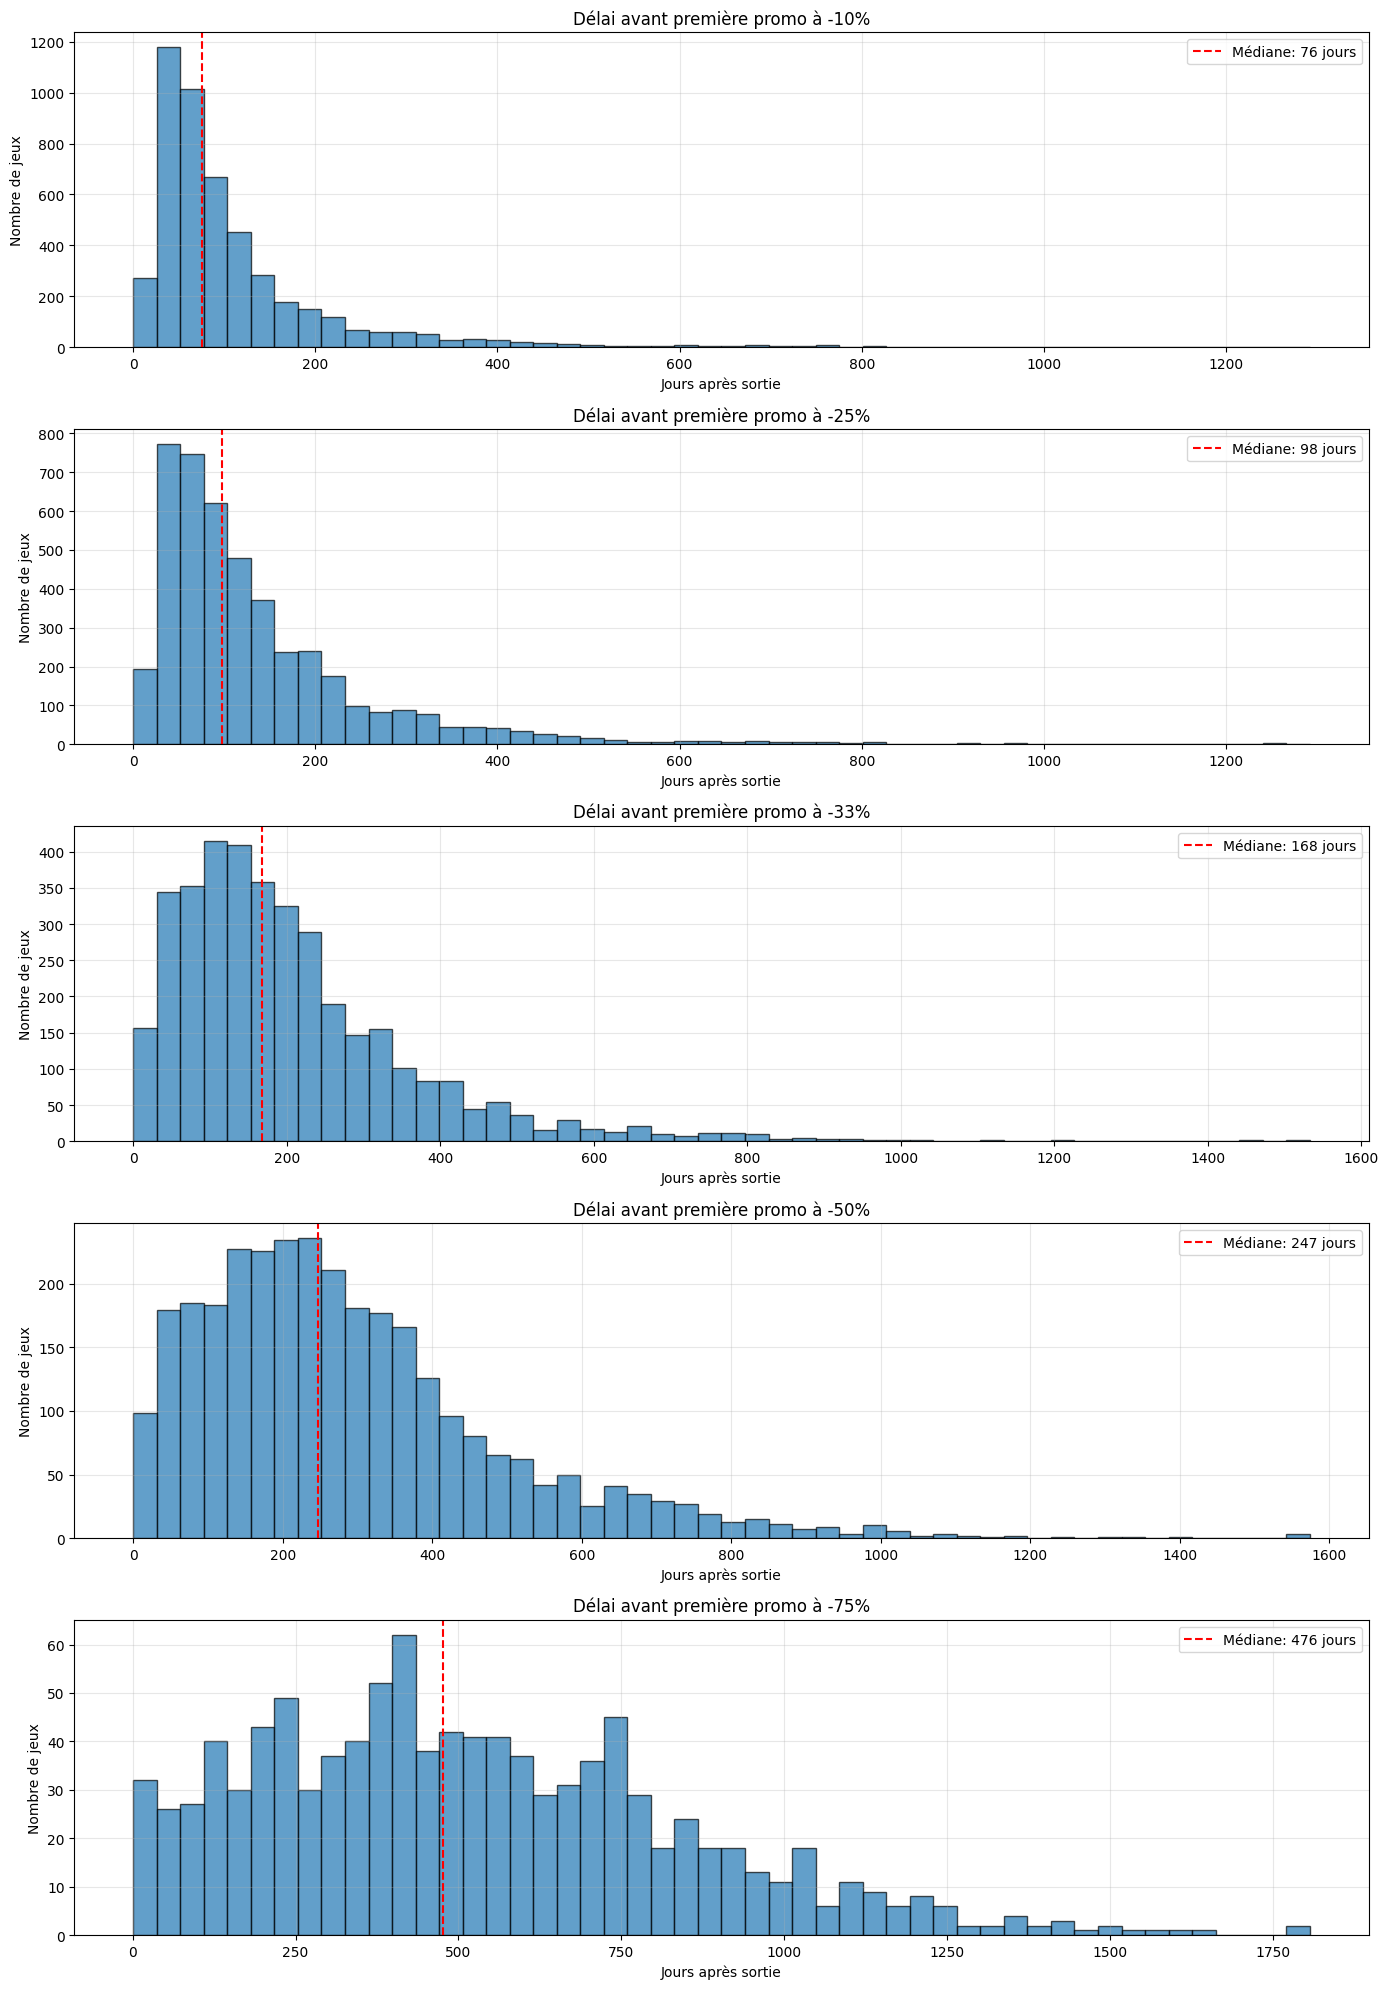

In [473]:
create_plots_day_to_promo(df_analyse_days_to_discount)

In [474]:
def day_to_promo_summary(df:pd.DataFrame):
    summary_data = []
    for promo in PROMOS:
        col = f'days_to_{promo}_percent_discount'
        summary_data.append({
            'Réduction': f'-{promo}%',
            'Jeux concernés': df[col].notna().sum(),
            'Pourcentage': f"{(df[col].notna().sum() / len(df)) * 100:.1f}%",
            'Médiane (jours)': df[col].median(),
            'Moyenne (jours)': df[col].mean(),
            'Min (jours)': df[col].min(),
            'Max (jours)': df[col].max()
        })

    summary_df = pd.DataFrame(summary_data)
    print("\n" + "="*80)
    print("RÉSUMÉ DES PROMOTIONS")
    print("="*80)
    print(summary_df.to_string(index=False))

In [475]:
day_to_promo_summary(df_analyse_days_to_discount)


RÉSUMÉ DES PROMOTIONS
Réduction  Jeux concernés Pourcentage  Médiane (jours)  Moyenne (jours)  Min (jours)  Max (jours)
     -10%            4778       88.8%             76.0       111.046463          0.0       1292.0
     -25%            4509       83.8%             98.0       139.444666          0.0       1292.0
     -33%            3714       69.0%            168.0       205.792138          0.0       1533.0
     -50%            3091       57.4%            247.0       290.918149          0.0       1574.0
     -75%            1025       19.0%            476.0       519.724878          1.0       1806.0


In [476]:
def create_wait_to_discount_category(df: pd.DataFrame, target_promo: int):
    df_copy = df.copy()
    target_col = f'days_to_{target_promo}_percent_discount'
    col_name = f'days_to_{target_promo}_percent_discount_category'
    
    # Extraire les bins et labels depuis WAIT_DISCOUNT_SEGMENTS
    bins = [segment['value_min'] for segment in WAIT_DISCOUNT_SEGMENTS] + [float('inf')]
    labels = [segment['label'] for segment in WAIT_DISCOUNT_SEGMENTS]
    
    # Créer les catégories
    df_copy[col_name] = pd.cut(
        df_copy[target_col],
        bins=bins,
        labels=labels,
        include_lowest=True,
        right=True
    )
    
    df_copy[col_name] = df_copy[col_name].astype(str)
    
    # Gérer les NaN pour days_since_release
    # le jeu n'a JAMAIS atteint une baisse de {target_promo}%
    mask_nan = df_copy[target_col].isna()
    
    # jeux récents (<2 ans) qui n'ont PAS ENCORE atteint {target_promo}%
    mask_recent = mask_nan & (df_copy['days_since_release'] < 730)
    df_copy.loc[mask_recent, col_name] = 'moins_de_2_ans_sans_baisse'
    
    # jeux anciens (>=2 ans) qui n'ont JAMAIS atteint {target_promo}%
    mask_old = mask_nan & (df_copy['days_since_release'] >= 730)
    df_copy.loc[mask_old, col_name] = 'jamais_ou_plus'
    
    # NaN dans days_since_release = jeu par encore sortis ou erreur de date de sortie
    mask_unknown = mask_nan & df_copy['days_since_release'].isna()
    df_copy.loc[mask_unknown, col_name] = 'moins_de_2_ans_sans_baisse'
    
    return df_copy

In [477]:
# Pour chaque seuil de promo on crée la colonne de catégorie associée
for promo in PROMOS:
    df_analyse_days_to_discount = create_wait_to_discount_category(df_analyse_days_to_discount, promo)

In [478]:
def pie_and_bar_charts_discount_categories_compact(df: pd.DataFrame):
    """
    Version autonome utilisant WAIT_DISCOUNT_SEGMENTS et PROMOS
    """
    # Créer la figure avec taille appropriée
    fig = plt.figure(figsize=(16, 20))
    
    # Couleurs pour chaque catégorie
    category_colors = {
        '0-3_mois': '#e74c3c',
        '3-6_mois': '#e67e22',
        '6-12_mois': '#f39c12',
        '1-2_ans': '#3498db',
        'moins_de_2_ans_sans_baisse': '#9b59b6',
        'jamais_ou_plus': '#95a5a6'
    }
    
    # Labels lisibles
    category_labels = {
        '0-3_mois': '0-3 mois',
        '3-6_mois': '3-6 mois',
        '6-12_mois': '6-12 mois',
        '1-2_ans': '1-2 ans',
        'moins_de_2_ans_sans_baisse': '< 2 ans sans baisse',
        'jamais_ou_plus': 'Jamais ou >2 ans'
    }
    
    # Ordre des catégories (depuis WAIT_DISCOUNT_SEGMENTS + ajout)
    category_order = [segment['label'] for segment in WAIT_DISCOUNT_SEGMENTS]
    category_order.insert(-1, 'moins_de_2_ans_sans_baisse')  # Avant 'jamais_ou_plus'
    
     
    # Statistiques globales
    print("STATISTIQUES PAR SEUIL DE PROMOTION")
    print("=" * 80)
    
    for idx, promo in enumerate(PROMOS):
        col_name = f'days_to_{promo}_percent_discount_category'
        
        # Stats dans la console
        print(f"\n-{promo}%:")
        category_counts = df[col_name].value_counts()
        for cat in category_order:
            if cat in category_counts.index:
                count = category_counts[cat]
                pct = count / len(df) * 100
                label = category_labels.get(cat, cat)
                print(f"  {label:25s}: {count:5d} ({pct:5.1f}%)")
        
        # Axes (grille len(PROMOS) x 2)
        ax_pie = plt.subplot(len(PROMOS), 2, idx * 2 + 1)
        ax_bar = plt.subplot(len(PROMOS), 2, idx * 2 + 2)
        
        # Ordonner selon category_order
        ordered_counts = pd.Series({cat: category_counts.get(cat, 0) for cat in category_order})
        ordered_counts = ordered_counts[ordered_counts > 0]
        
        # Préparer couleurs et labels
        colors = [category_colors[cat] for cat in ordered_counts.index]
        labels = [category_labels.get(cat, cat) for cat in ordered_counts.index]
        
        # === PIE CHART ===
        wedges, texts, autotexts = ax_pie.pie(
            ordered_counts.values,
            autopct=lambda pct: f'{pct:.1f}%' if pct > 3 else '',
            startangle=90,
            colors=colors,
            wedgeprops={'edgecolor': 'white', 'linewidth': 2}
        )
        
        for autotext in autotexts:
            autotext.set_color('white')
            autotext.set_fontweight('bold')
            autotext.set_fontsize(9)
        
        ax_pie.set_title(f'Réduction de {promo}%\n(Proportions)', 
                        pad=15, fontweight='bold', fontsize=12)
        
        # === BAR CHART HORIZONTAL ===
        bars = ax_bar.barh(
            range(len(ordered_counts)),
            ordered_counts.values,
            color=colors,
            edgecolor='black',
            linewidth=1.5
        )
        
        ax_bar.set_yticks(range(len(ordered_counts)))
        ax_bar.set_yticklabels(labels, fontsize=9)
        ax_bar.set_xlabel('Nombre de jeux', fontsize=10)
        ax_bar.set_title(f'Réduction de {promo}%\n(Quantités)', 
                        pad=15, fontweight='bold', fontsize=12)
        ax_bar.grid(axis='x', alpha=0.3, linestyle='--')
        ax_bar.invert_yaxis()
        
        # Valeurs sur les barres
        max_val = ordered_counts.max()
        for i, (bar, val) in enumerate(zip(bars, ordered_counts.values)):
            ax_bar.text(
                val + max_val * 0.01,
                bar.get_y() + bar.get_height() / 2,
                f'{int(val)}',
                va='center',
                fontsize=9,
                fontweight='bold'
            )
    
    fig.suptitle('Analyse de la vitesse de baisse de prix selon les seuils de promotion', 
                 fontsize=16, fontweight='bold')
    
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

STATISTIQUES PAR SEUIL DE PROMOTION

-10%:
  0-3 mois                 :  2898 ( 53.8%)
  3-6 mois                 :  1161 ( 21.6%)
  6-12 mois                :   533 (  9.9%)
  1-2 ans                  :   160 (  3.0%)
  < 2 ans sans baisse      :   559 ( 10.4%)
  Jamais ou >2 ans         :    71 (  1.3%)

-25%:
  0-3 mois                 :  2090 ( 38.8%)
  3-6 mois                 :  1349 ( 25.1%)
  6-12 mois                :   799 ( 14.8%)
  1-2 ans                  :   237 (  4.4%)
  < 2 ans sans baisse      :   813 ( 15.1%)
  Jamais ou >2 ans         :    94 (  1.7%)

-33%:
  0-3 mois                 :   854 ( 15.9%)
  3-6 mois                 :  1145 ( 21.3%)
  6-12 mois                :  1244 ( 23.1%)
  1-2 ans                  :   414 (  7.7%)
  < 2 ans sans baisse      :  1367 ( 25.4%)
  Jamais ou >2 ans         :   358 (  6.7%)

-50%:
  0-3 mois                 :   449 (  8.3%)
  3-6 mois                 :   592 ( 11.0%)
  6-12 mois                :  1216 ( 22.6%)
  1-2 ans   

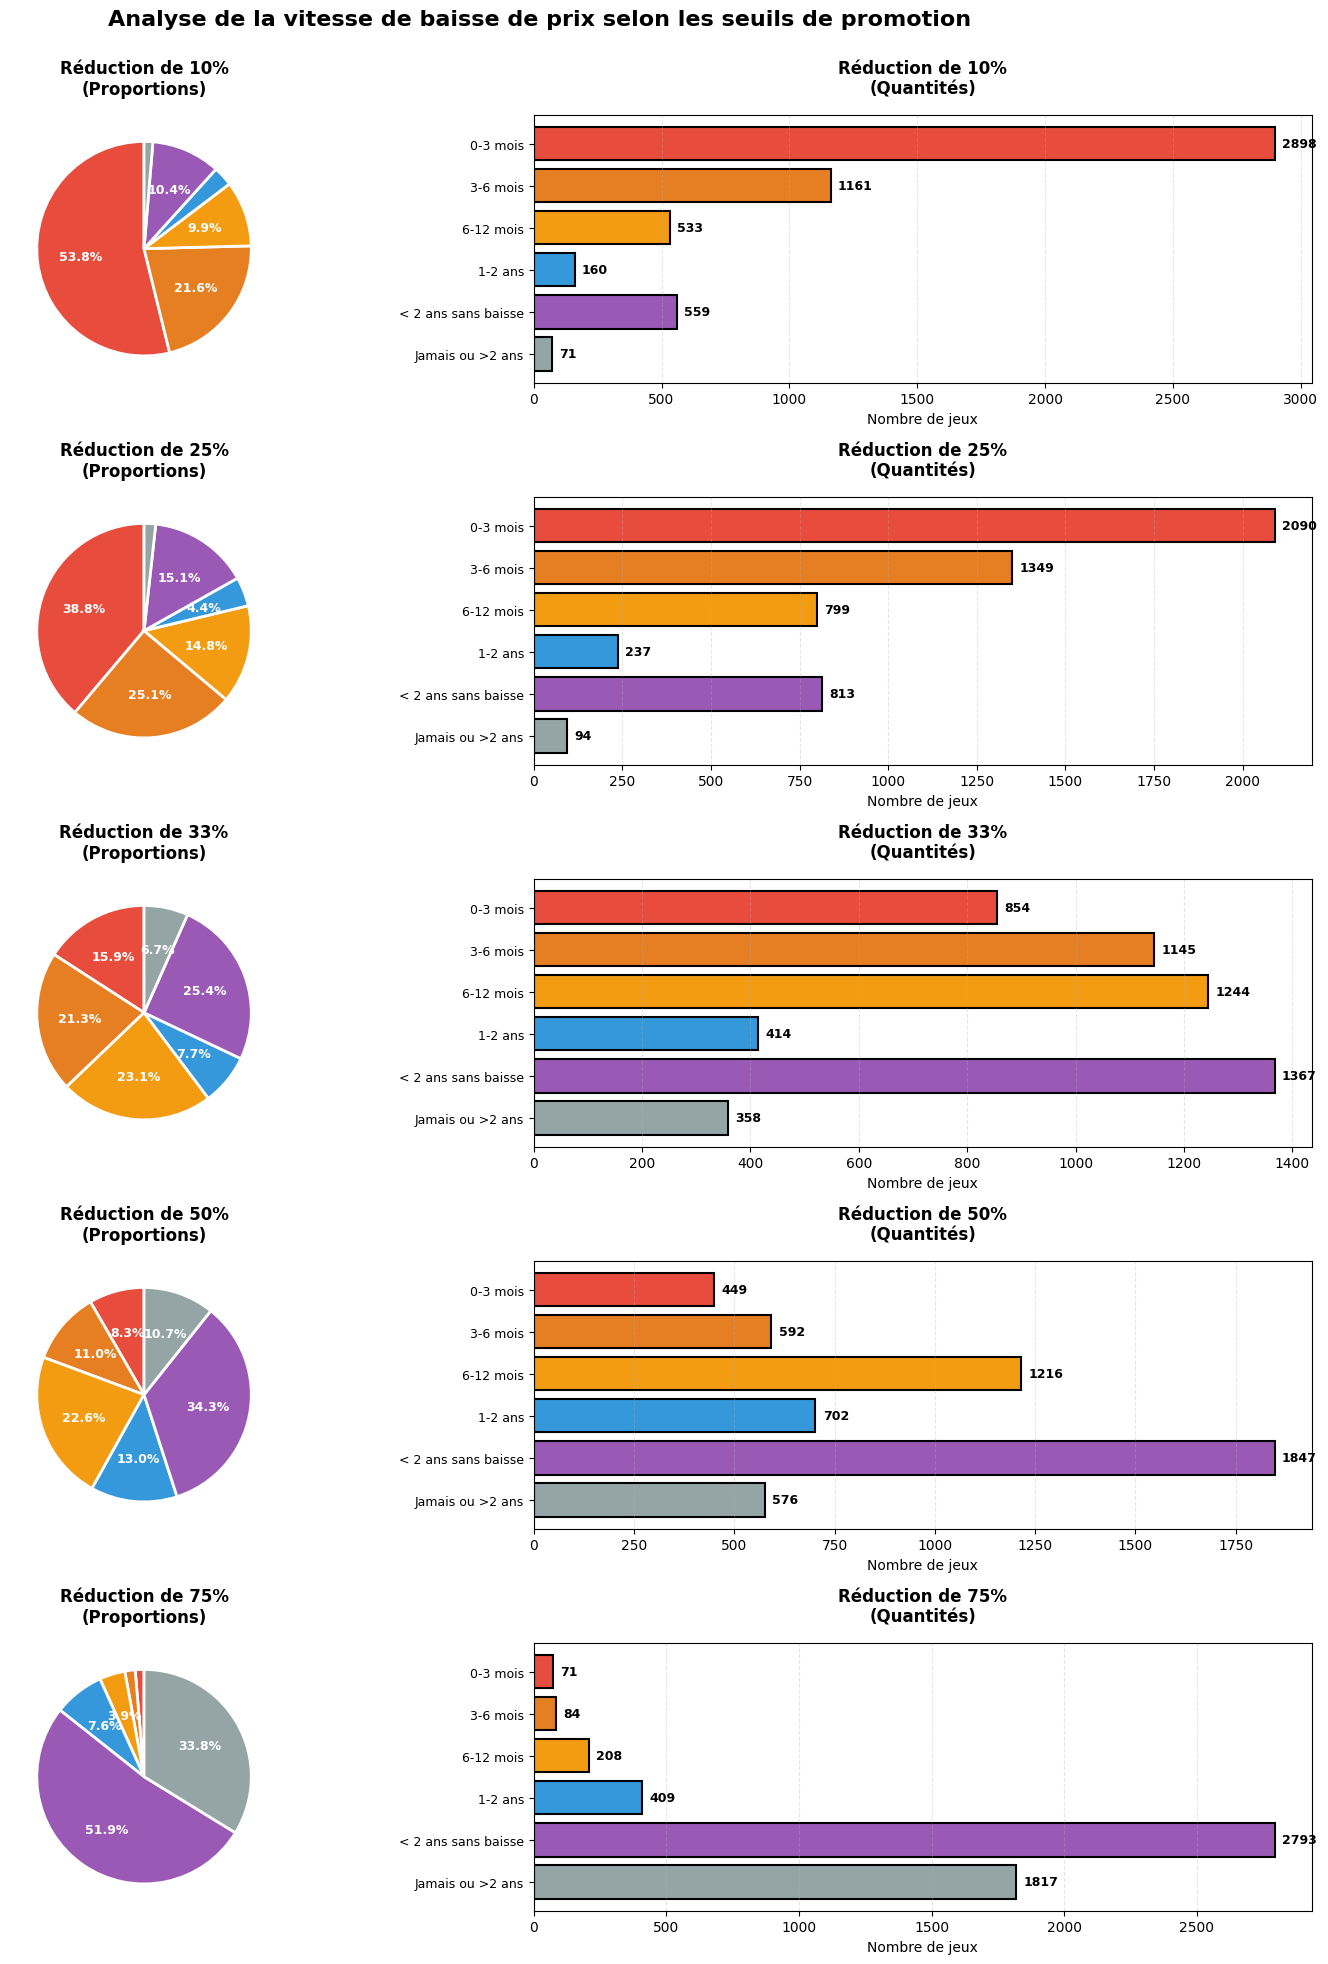

In [479]:
pie_and_bar_charts_discount_categories_compact(df_analyse_days_to_discount)

## Visualiser les corrélations

In [480]:
# On vérifie que les données n'on pas été modifiées durant la première phase d'exploration
column_summary(df)

Résumé détaillé des colonnes:
                        Column    Type  Non-Null Count  Null Count  Unique Values
                     game_name  object            5382           0           5382
                      id_store  object            5382           0           5382
                short_url_name  object            5382           0           5382
                     publisher  object            5382           0           1061
                     developer  object            3920        1462           2709
                  release_date  object            5382           0           1347
         pssstore_stars_rating float64            5382           0            352
   pssstore_stars_rating_count   int64            5382           0           1583
       metacritic_critic_score   Int64            1268        4114             67
   metacritic_critic_userscore   Int64            1268        4114             10
                        genres  object            5360          22  

### Matrice de corrélation (inclure features catégorielles)

In [498]:
df_for_afc_2 = df.copy()

In [499]:
# Convertir la colonne price_history de JSON vers list
df_for_afc_2['price_history'] = df_for_afc_2['price_history'].apply(
    lambda x: json.loads(x) if isinstance(x, str) else x
)

# Intégration des colonnes nombre de jours avant baisse de prix
df_for_afc_2 = generate_analyse_day_to_discount_df_data(df_for_afc_2)

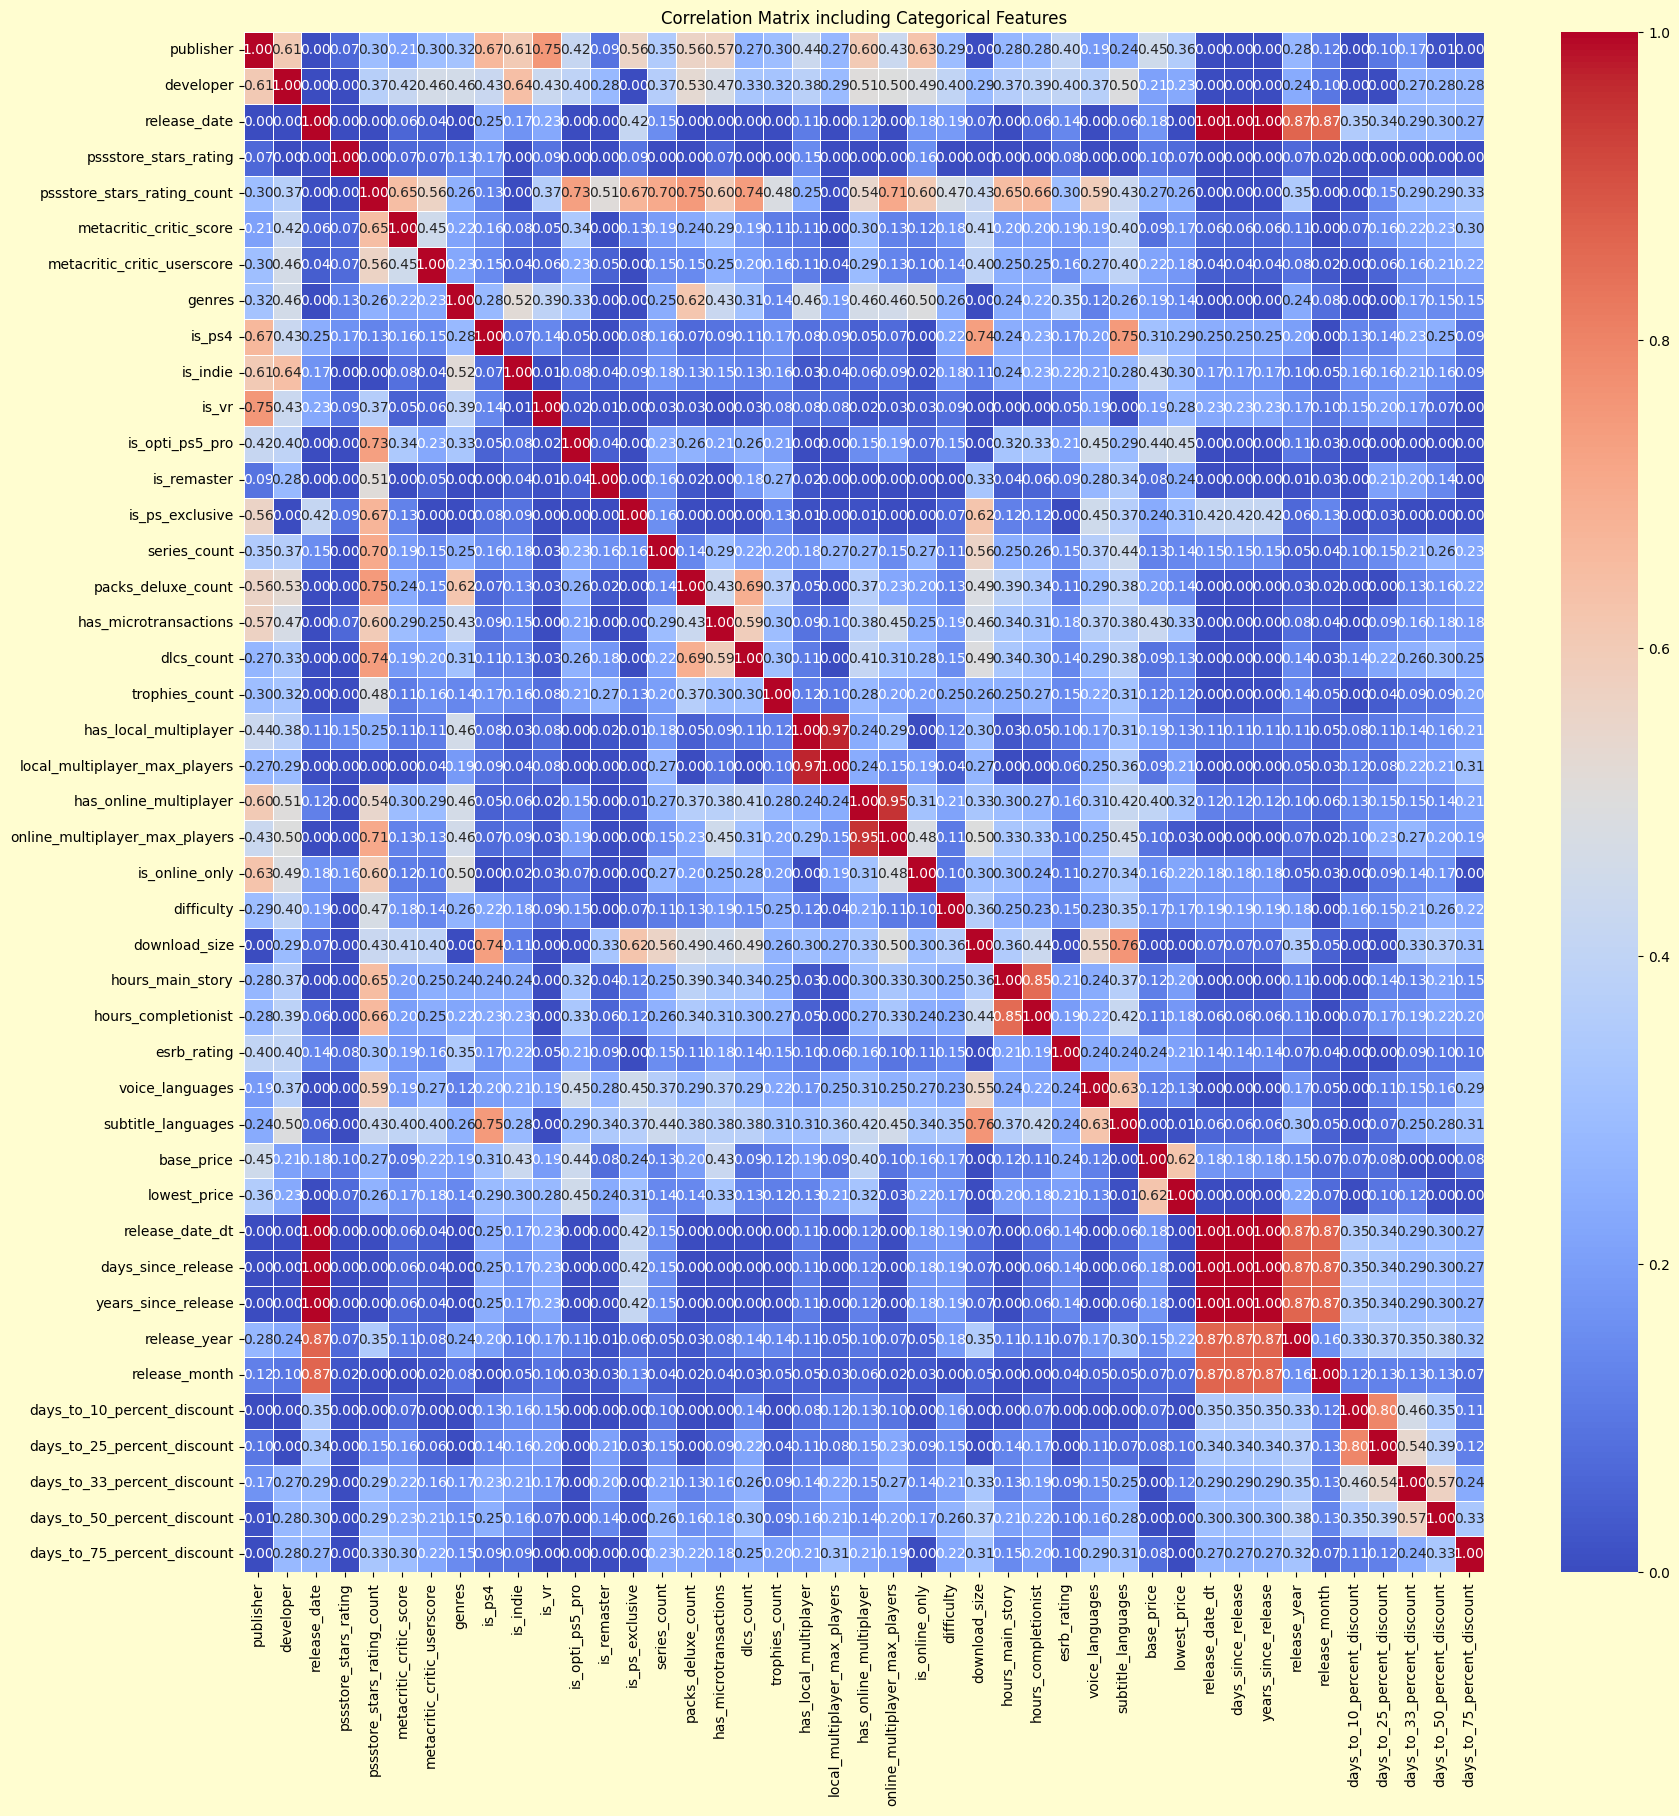

In [ ]:

from dython.nominal import associations

# Transformation dates
df_for_afc_2 = create_data_analyse_release_dates(df_for_afc_2,today=EXTRACT_DATE)
    # df['days_since_release']
    # df['years_since_release']
    # df['release_year']
    # df['release_month']

feature_columns_to_drop = [
    'is_dlc',
    'game_name',
    'id_store',
    'short_url_name',
    'rating_descriptions',
    'price_history',
    'is_ps5'
]

df_for_afc_2 = df_for_afc_2.drop(columns=feature_columns_to_drop,errors='ignore')

associations_df = associations(df_for_afc_2, nominal_columns='all', plot=False)
corr_matrix = associations_df['corr']
plt.figure(figsize=(20, 20))
plt.gcf().set_facecolor('#FFFDD0') 
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix including Categorical Features')
plt.show()

## Conclusion

- Les données sont cohérentes et réaliste pour un marché du jeux vidéo
- Les relations entre la baisse de prix et les features disponible sont légères
- La popularité (nombre de votes) forte corrélation avec les features

Dans la prochaine étape, création des features à prédire à partir de l'historique de prix.

Expérimentation sur la création de features d'intéractions supplémentaire pour aider la prédiction.